# Forecasting Using Supervised Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

import sktime
import statsmodels as sm
import matplotlib 
import sklearn

print(f'''
sktime ->  {sktime.__version__}
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
sklearn -> {sklearn.__version__}
statsmodels -> {sm.__version__}
''')


###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################




sktime ->  0.12.0
Matplotlib -> 3.5.2
pandas -> 1.4.4   
numpy -> 1.22.3
sklearn -> 1.1.3
statsmodels -> 0.13.2



In [2]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)


def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()


def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test


class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]




In [3]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata


def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results


def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

In [4]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

<Day>
<MonthBegin>
<MonthEnd>


<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

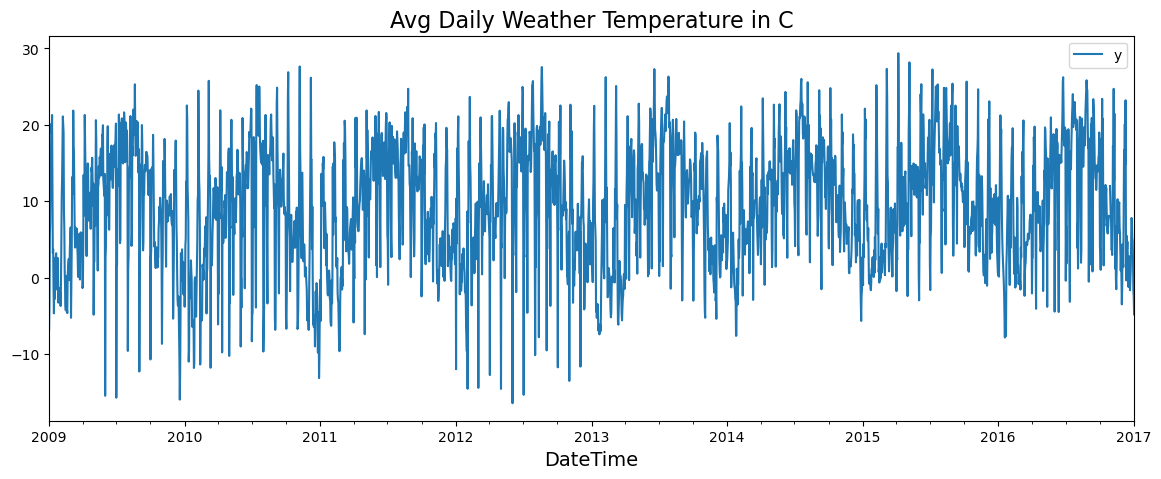

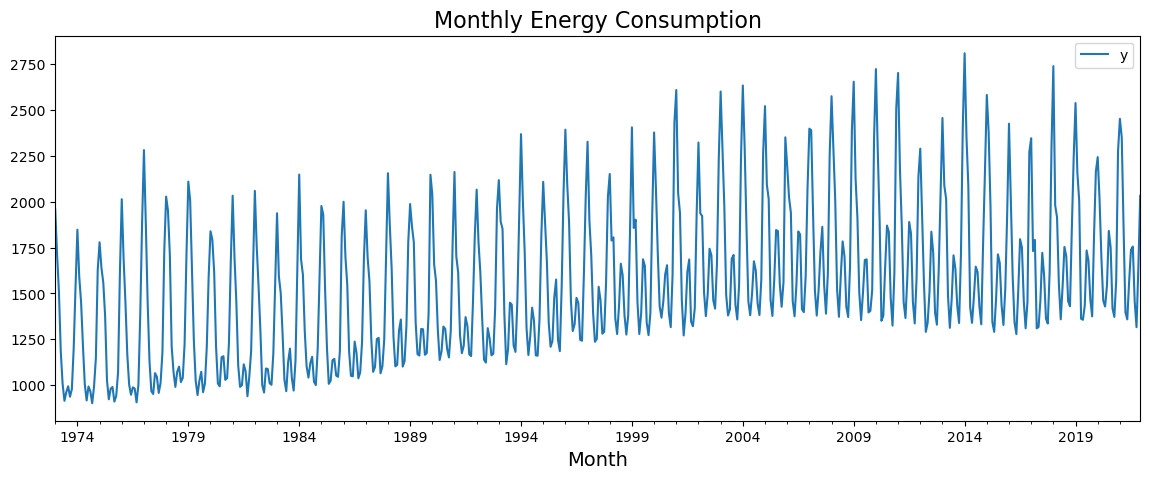

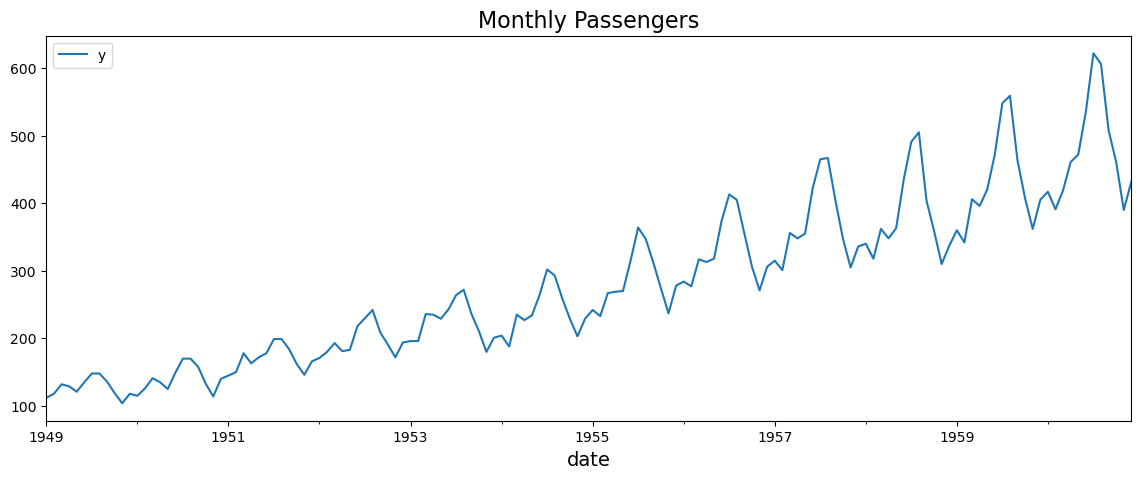

In [6]:
path = r'./CodeAndDatasets/datasets/Ch12/'
daily_temp = pd.read_csv(path + 'daily_weather.csv', 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path+'energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path+'air_passenger.csv', 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)


plt.rcParams["figure.figsize"] = [14, 5]  
daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

## Preparing Time Series Data for Supervised Learning

Steps to follow:

* Inspect timeseries data for missing values and impute with imputation / interpolation techniques
* Understand any stationary assumption in the algorithm before fitting model. if statsionarity is an assumption before training, then transform the time series.
* Transform your time series to contain Indepenedent variables and dependent variable by defining a sliding window to convert data into window of inputs.
* split data into train test sets
* scale data based on the algorithm. results should be inverse transformed to restore to original scale.

In [7]:
air_copy = air.copy()
energy_copy = energy.copy()
daily_temp_copy = daily_temp.copy()

## Inspect timeseries data for missing values and impute with imputation / interpolation techniques

for df in [air_copy, energy_copy, daily_temp_copy]:
    handle_missing_data(df)

## one_step_forecast function will transform a time series with a 
  # specified number of steps (the sliding window size)

air_os = one_step_forecast(air_copy, 5)
energy_os = one_step_forecast(energy_copy, 5)
daily_temp_os = one_step_forecast(daily_temp_copy, 5)
print(air_os.shape)
print(energy_os.shape)
print(daily_temp_os.shape)

air_os

found 2 missing observations...
(139, 6)
(583, 6)
(2918, 6)


x_1  x_2  x_3  x_4  x_5    y
date                                    
1949-01-31  112  118  132  129  121  135
1949-02-28  118  132  129  121  135  148
1949-03-31  132  129  121  135  148  148
1949-04-30  129  121  135  148  148  136
1949-05-31  121  135  148  148  136  119
...         ...  ...  ...  ...  ...  ...
1960-03-31  419  461  472  535  622  606
1960-04-30  461  472  535  622  606  508
1960-05-31  472  535  622  606  508  461
1960-06-30  535  622  606  508  461  390
1960-07-31  622  606  508  461  390  432

[139 rows x 6 columns]

In [8]:
train, test = split_data(air_os)
print(f'Train: {len(train)} Test: {len(test)}')

scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

Train: 119 Test: 20


x_1       x_2       x_3       x_4       x_5         y
date                                                                  
1949-01-31 -1.401933 -1.364908 -1.240908 -1.294771 -1.398791 -1.273682
1949-02-28 -1.338755 -1.216817 -1.272708 -1.379791 -1.250613 -1.136238
1949-03-31 -1.191342 -1.248551 -1.357508 -1.231006 -1.113020 -1.136238
1949-04-30 -1.222930 -1.333174 -1.209108 -1.092848 -1.113020 -1.263109
1949-05-31 -1.307167 -1.185083 -1.071309 -1.092848 -1.240029 -1.442843

In [9]:
y_train_original = scaler.inverse_y(train_s['y'])

train_original = scaler.inverse(train_s)
train_original.head()

x_1    x_2    x_3    x_4    x_5      y
date                                                
1949-01-31  112.0  118.0  132.0  129.0  121.0  135.0
1949-02-28  118.0  132.0  129.0  121.0  135.0  148.0
1949-03-31  132.0  129.0  121.0  135.0  148.0  148.0
1949-04-30  129.0  121.0  135.0  148.0  148.0  136.0
1949-05-31  121.0  135.0  148.0  148.0  136.0  119.0

In [10]:
## you could create new columns based on the date column, such as day of the week, year, month, 
# quarter, season, and other date-time features. 

df = daily_temp.copy()
df['day_of_week'] = df.index.dayofweek
df['days_in_month'] = df.index.days_in_month
df['month_end'] = df.index.is_month_end.astype(int)
df['is_leap'] = df.index.is_leap_year.astype(int)
df['month'] = df.index.month
df.head()

y  day_of_week  days_in_month  month_end  is_leap  month
DateTime                                                                    
2009-01-01  -6.810629            3             31          0        0      1
2009-01-02  -3.360486            4             31          0        0      1
2009-01-03   5.435694            5             31          0        0      1
2009-01-04   7.283889            6             31          0        0      1
2009-01-05  12.690069            0             31          0        0      1

## One-Step Forecasting using Linear Regression Models with Scikit-Learn

In [11]:
from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor) ## linear models

air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)

print(air_reg.shape)
print(en_reg.shape)
print(dw_reg.shape)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()


train_air, test_air = split_data(air_reg, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)

train_en, test_en = split_data(en_reg, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)

train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

## train on multiple regression models

regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)



found 2 missing observations...
(134, 11)
(578, 11)
(2913, 11)
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [12]:
## Evaluate prediction results
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
2   Ridge Regression  0.381092  0.202191  1.390807
0  Linear Regression  0.385559  0.205371  1.411072
4   Huber Regression  0.400949  0.214912  1.457932
1        Elastic Net  0.829023  0.328472  2.808737
3   Lasso Regression  1.190006  0.551243  4.439302

In [13]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  1.419527  0.525526
2   Ridge Regression  0.433192  1.586383  0.560450
0  Linear Regression  0.433747  1.583406  0.560989
1        Elastic Net  0.747657  1.822362  1.013425
3   Lasso Regression  0.834356  1.548537  1.108092

In [14]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.655729  1.083826  0.968735
0  Linear Regression  0.646648  1.037424  0.990057
2   Ridge Regression  0.646639  1.037273  0.990085
1        Elastic Net  0.737896  0.913599  1.300792
3   Lasso Regression  0.814609  0.911730  1.468567

#### Air Passengers Plots

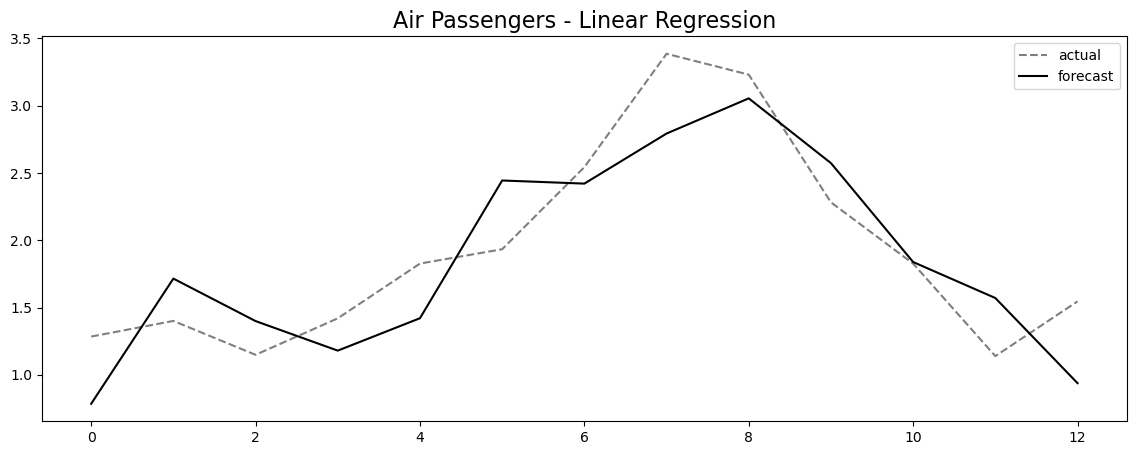

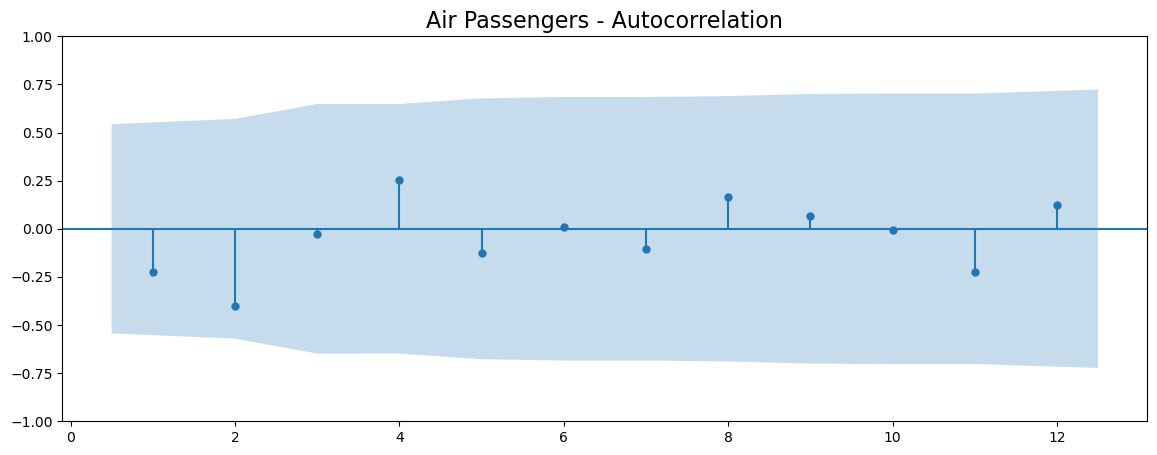

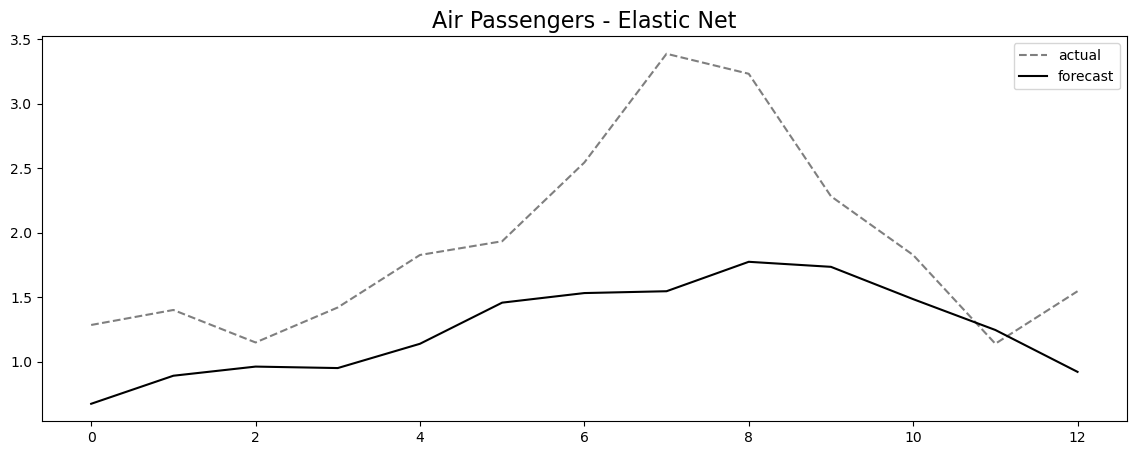

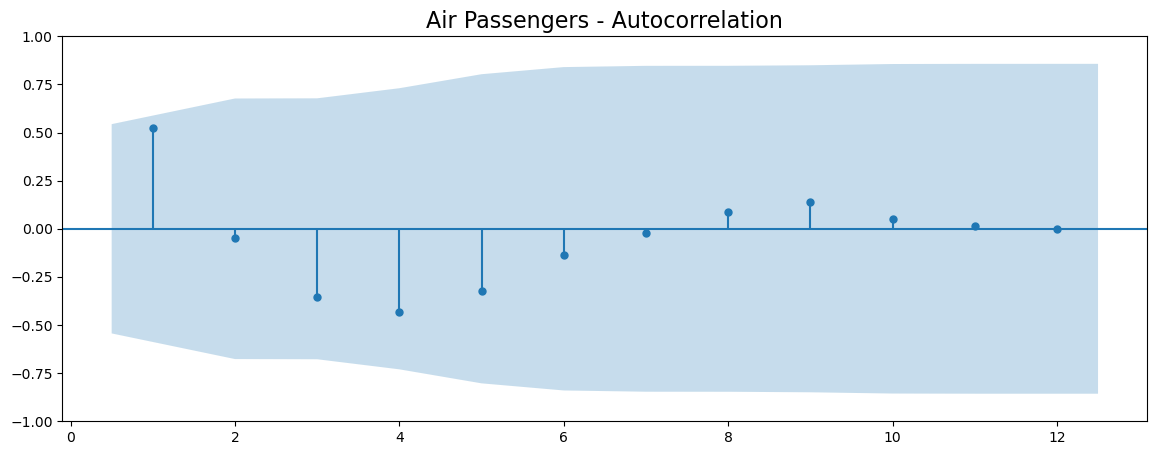

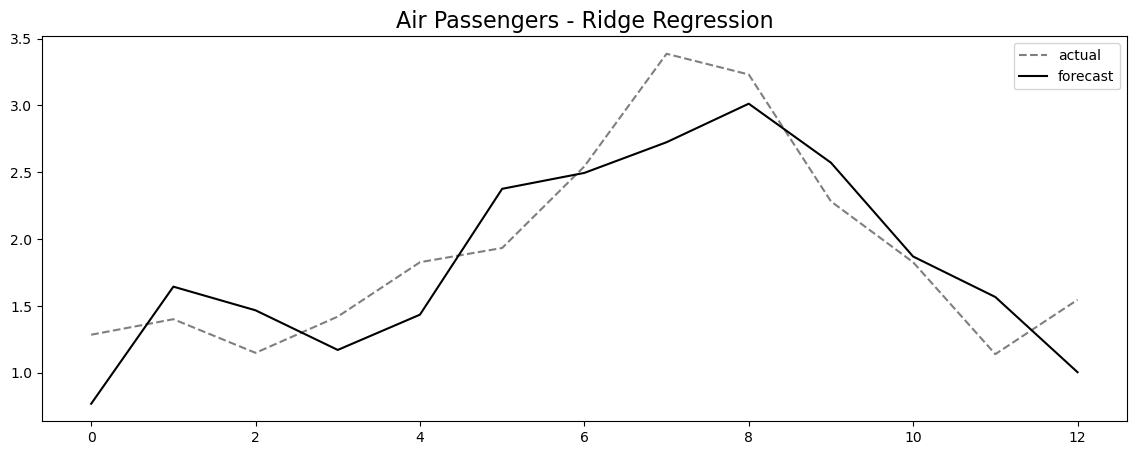

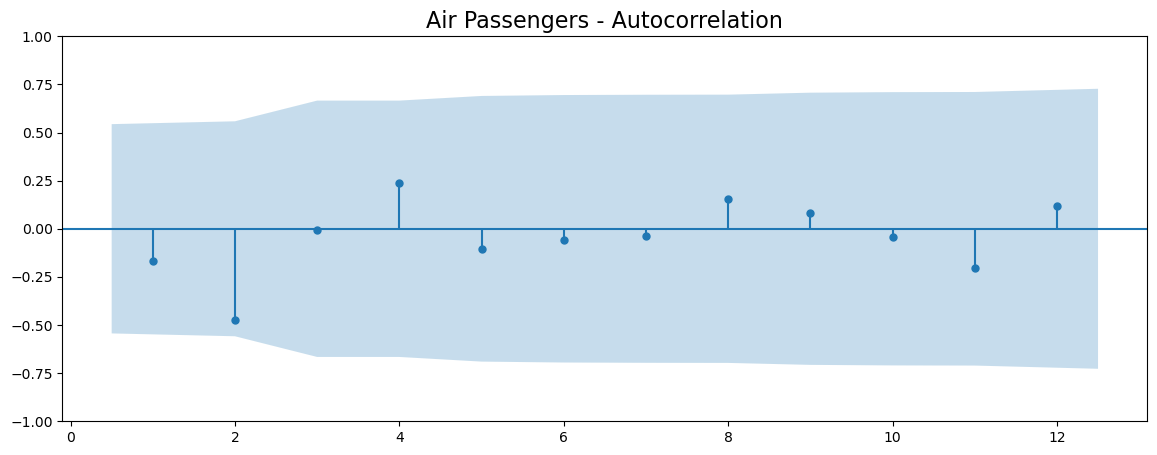

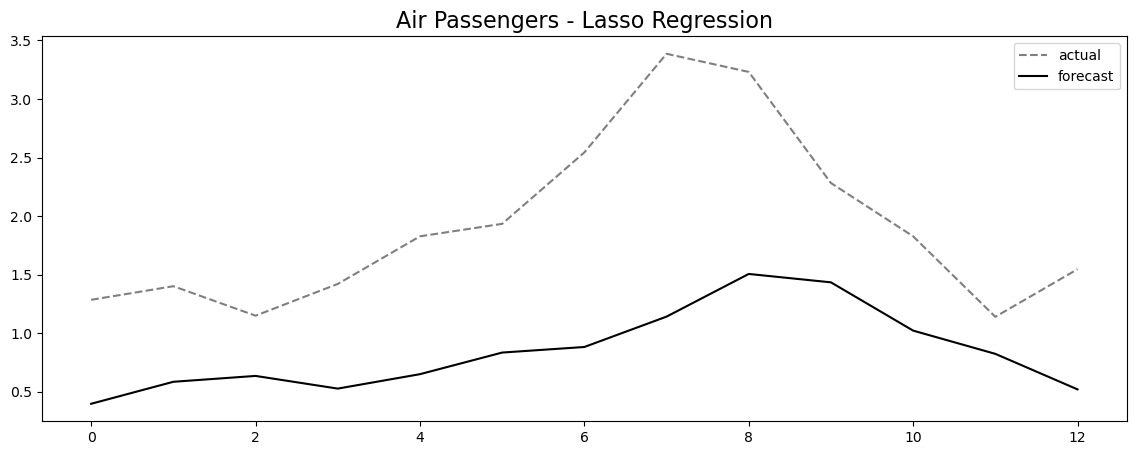

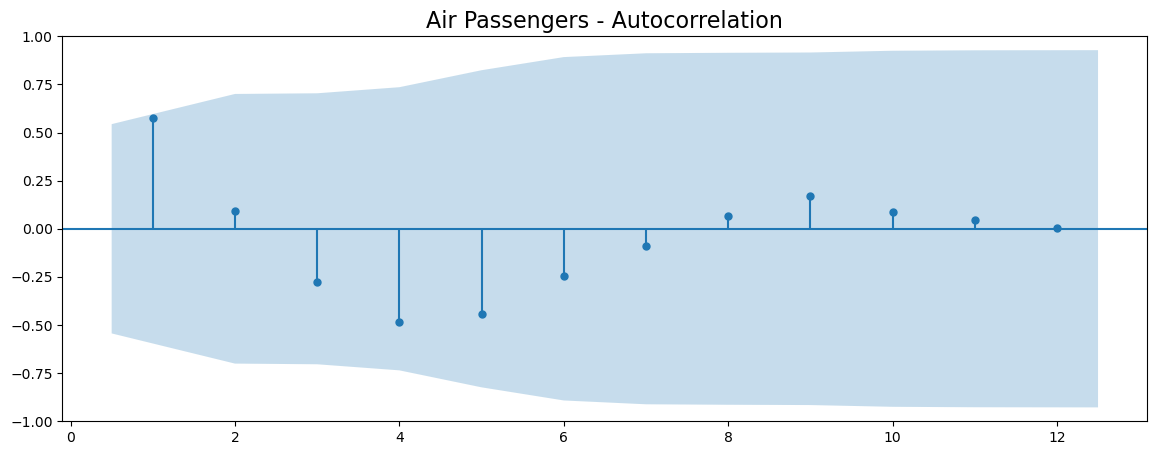

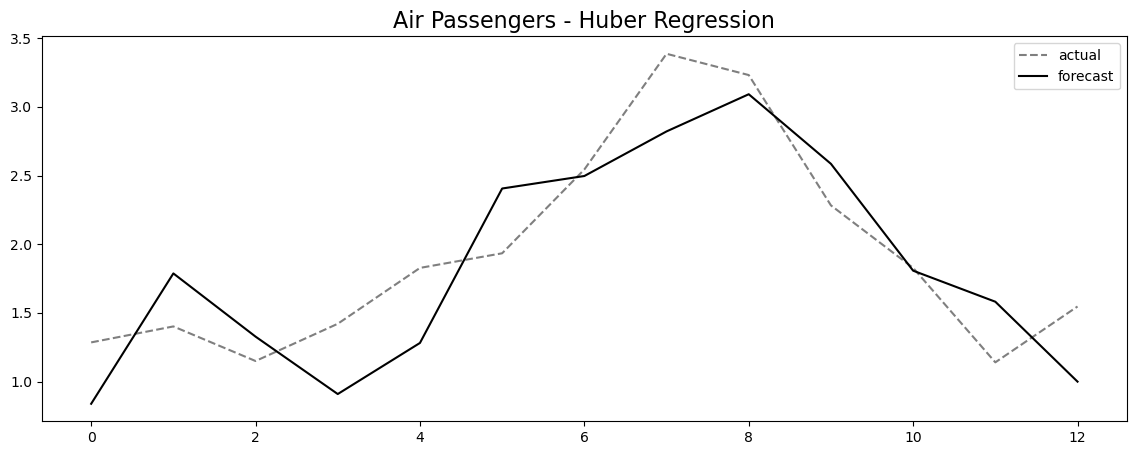

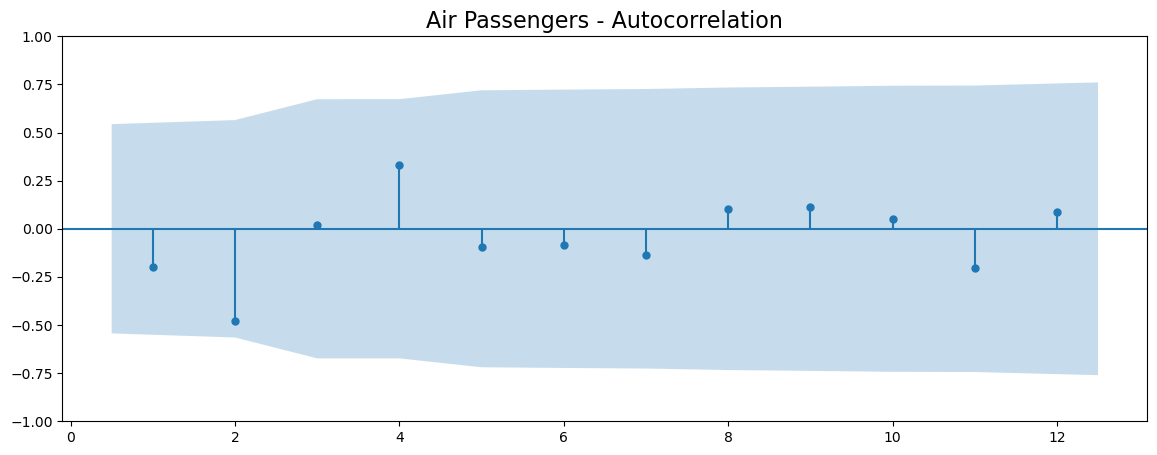

In [15]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')

#### Energy Consumption Plots

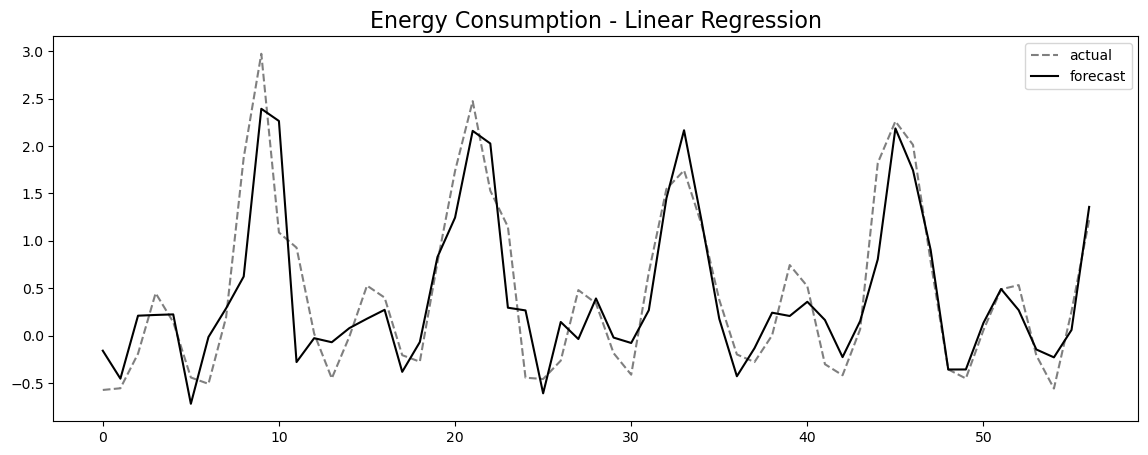

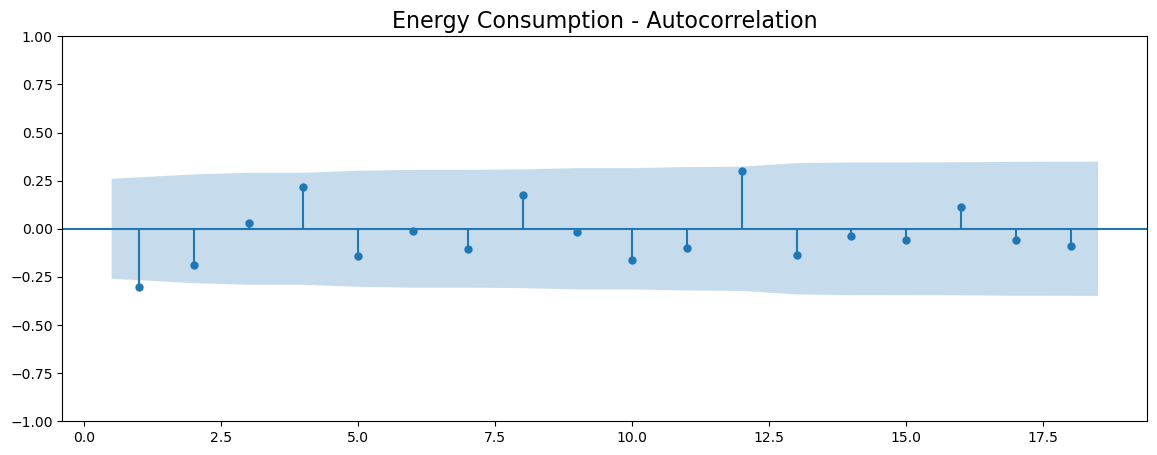

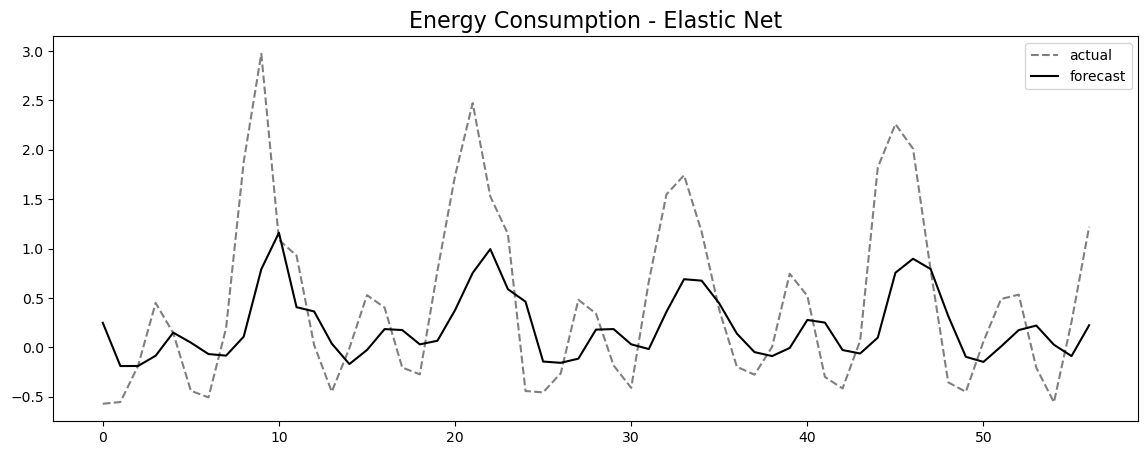

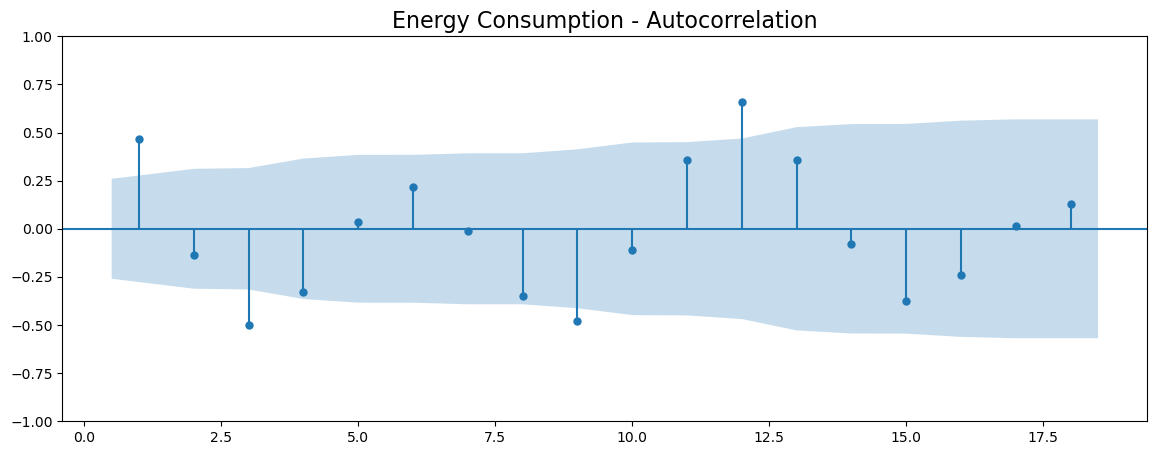

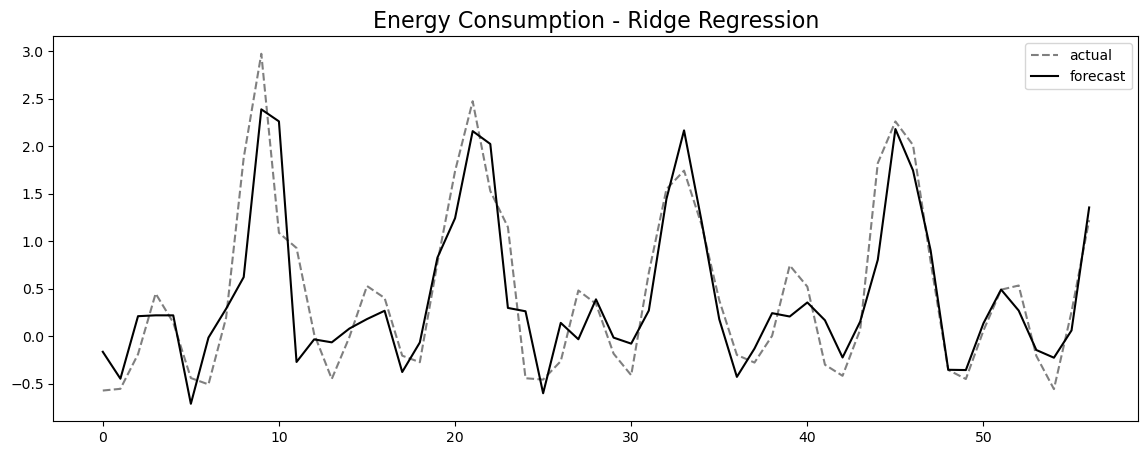

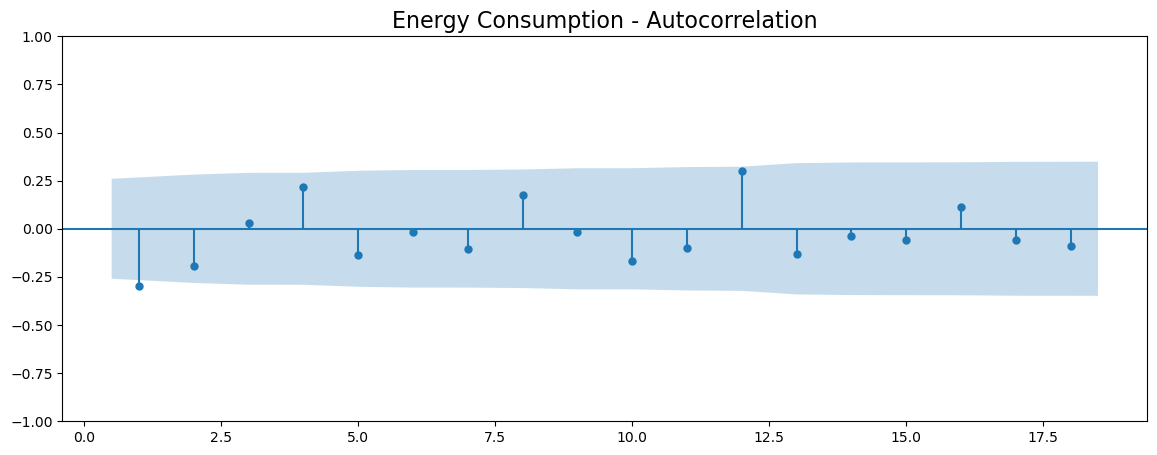

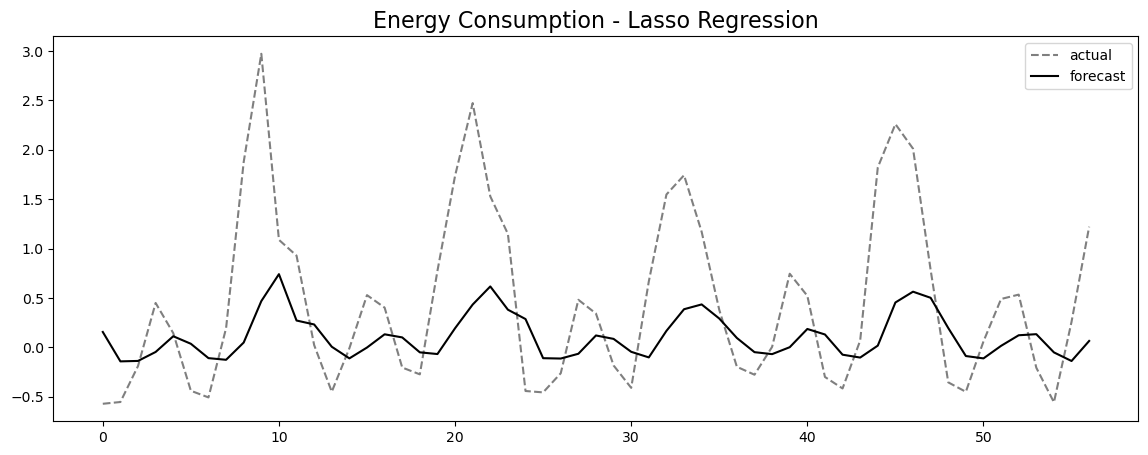

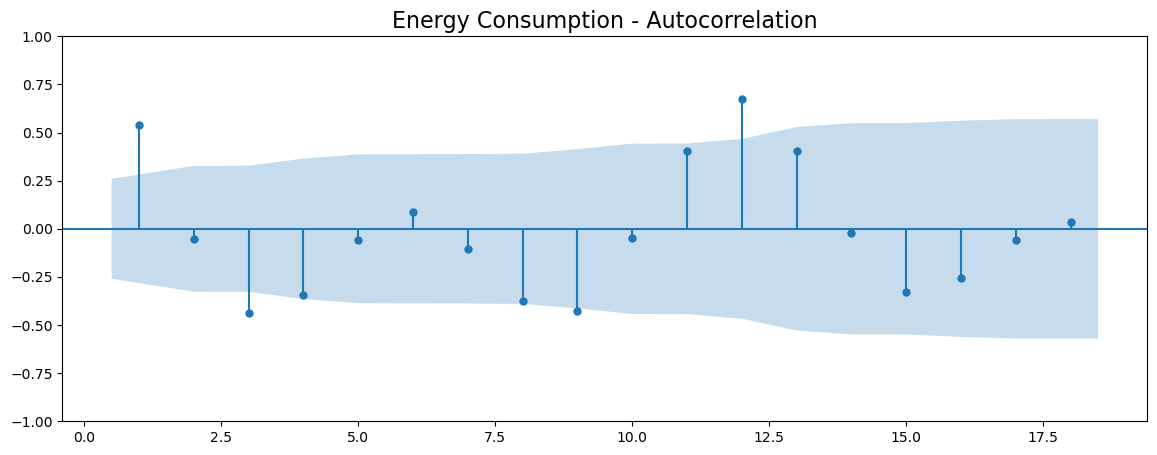

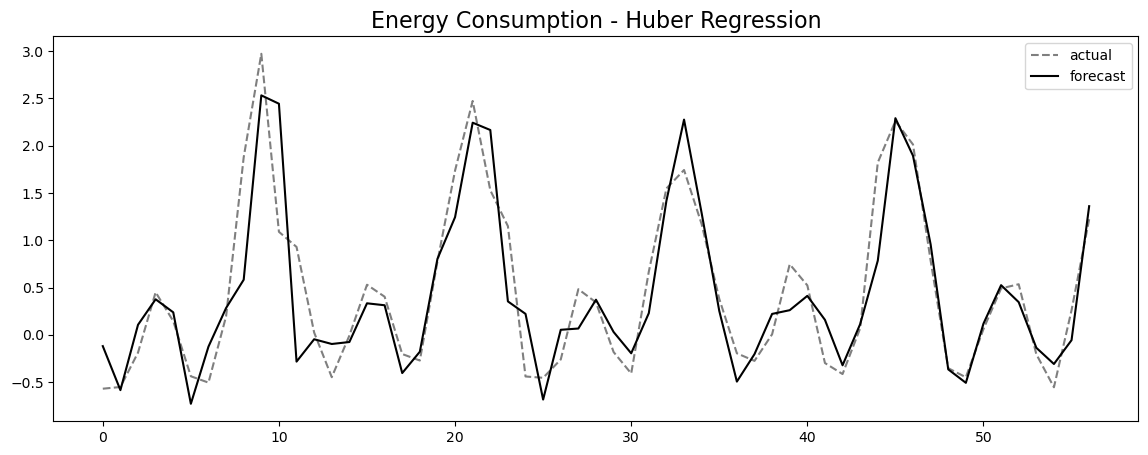

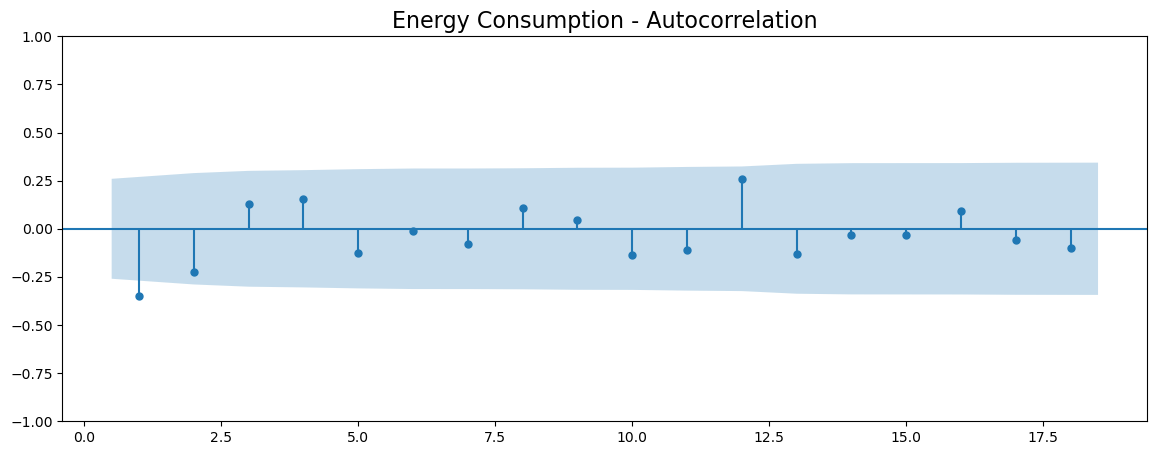

In [16]:
plot_results(cols, en_results, 'Energy Consumption')

#### Daily Temperature Plots

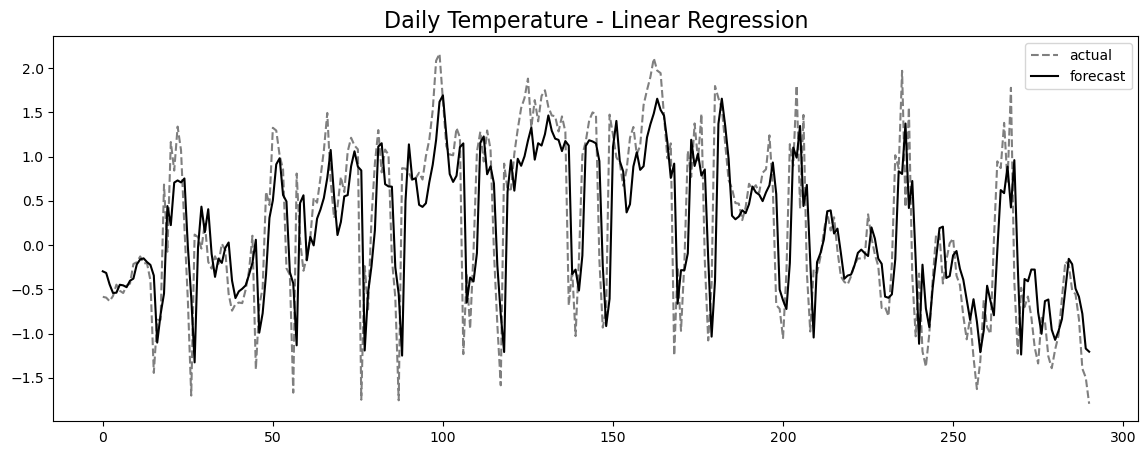

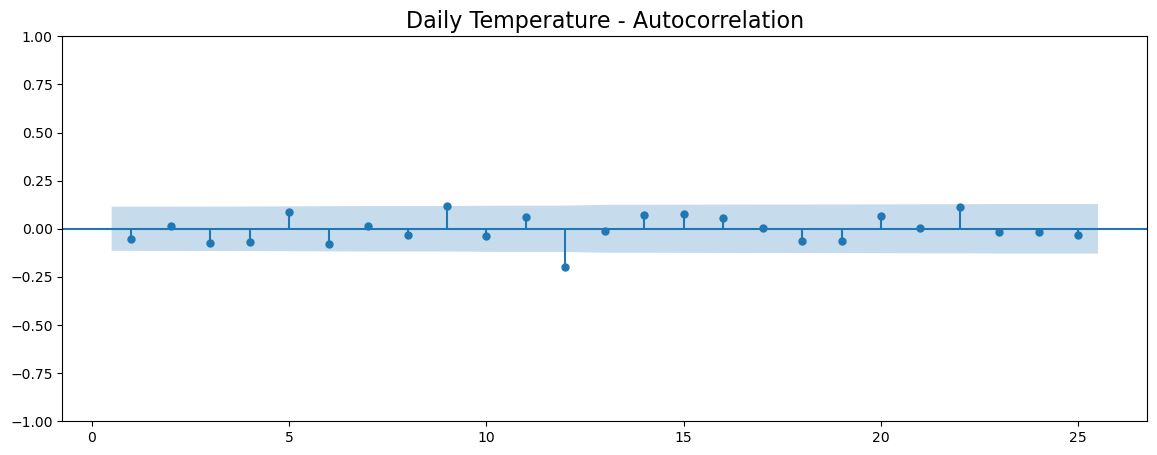

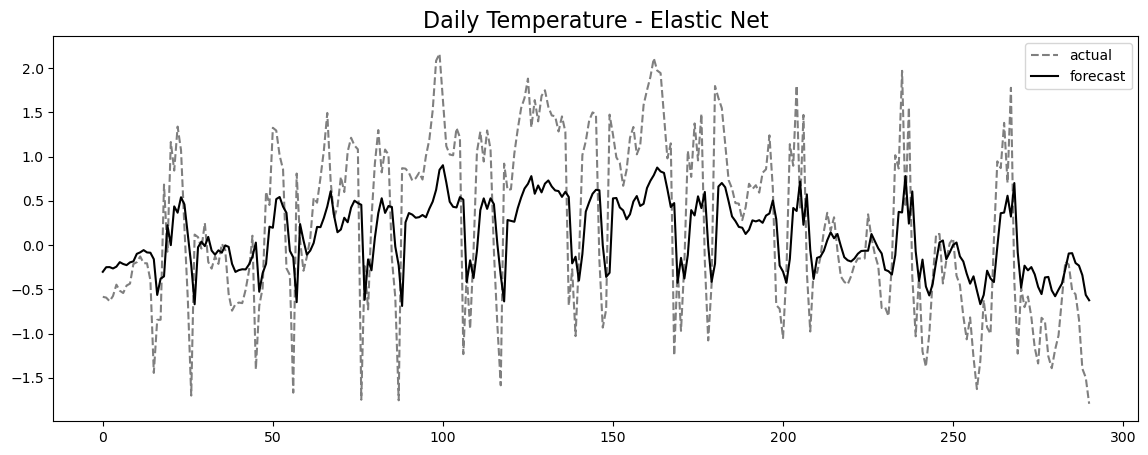

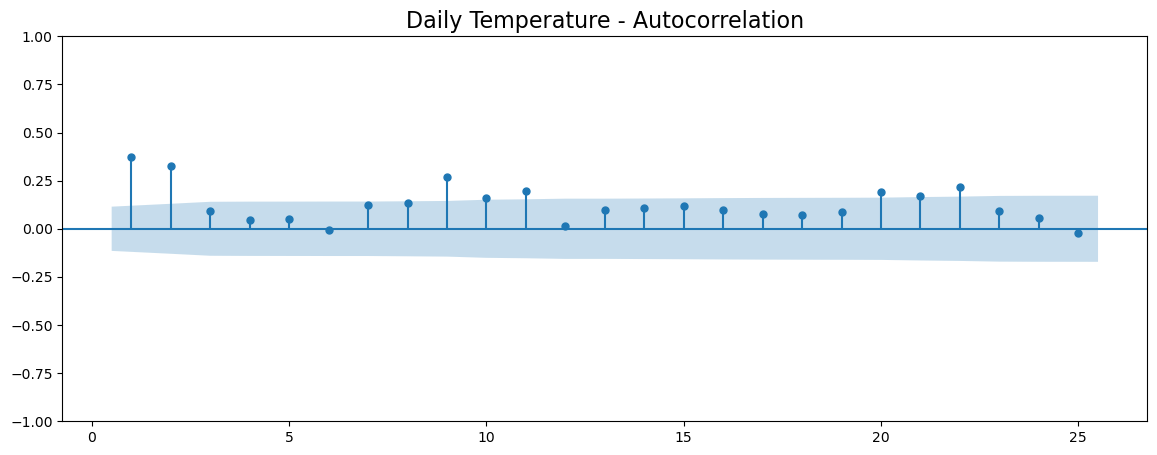

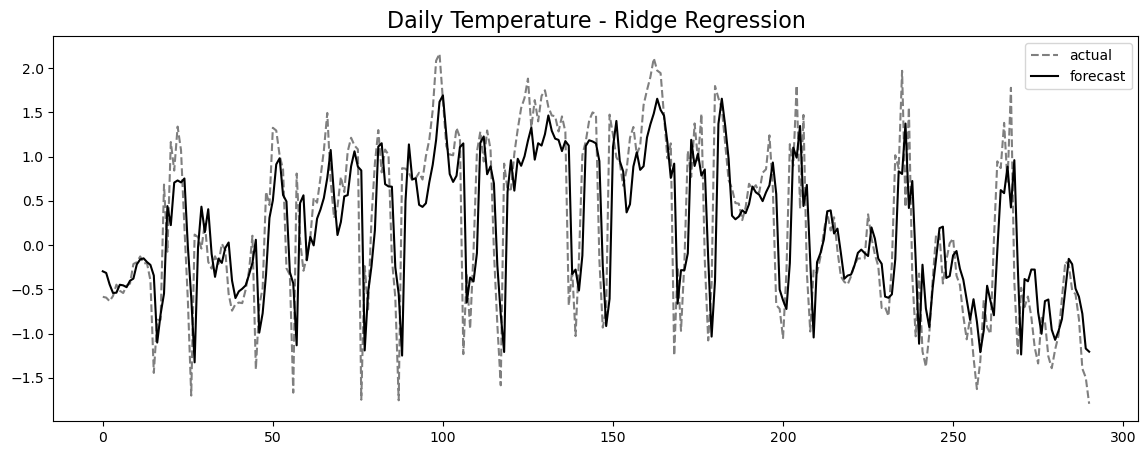

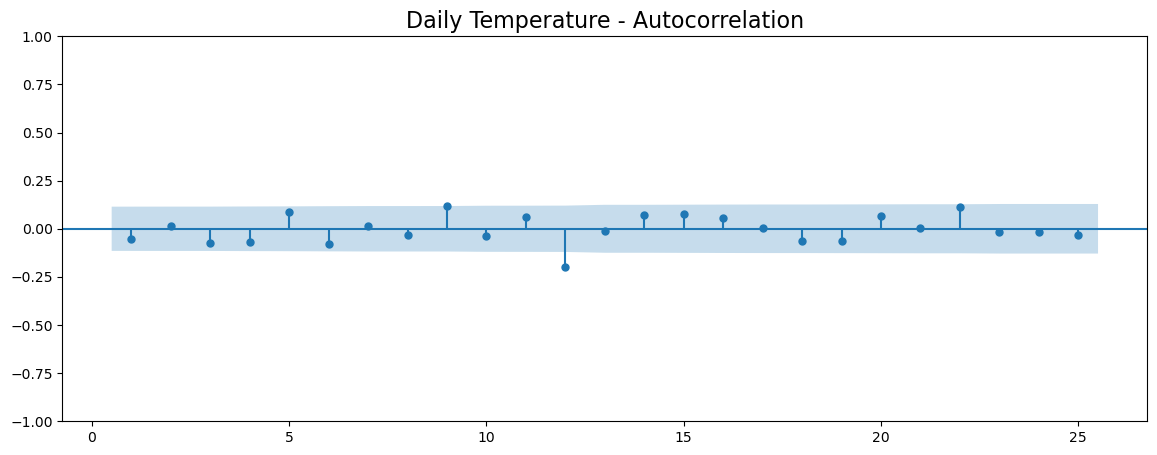

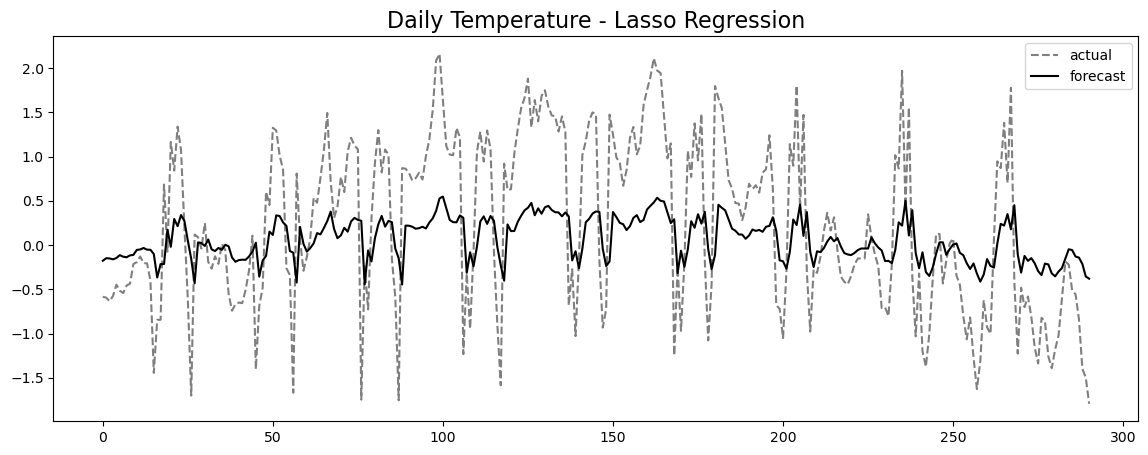

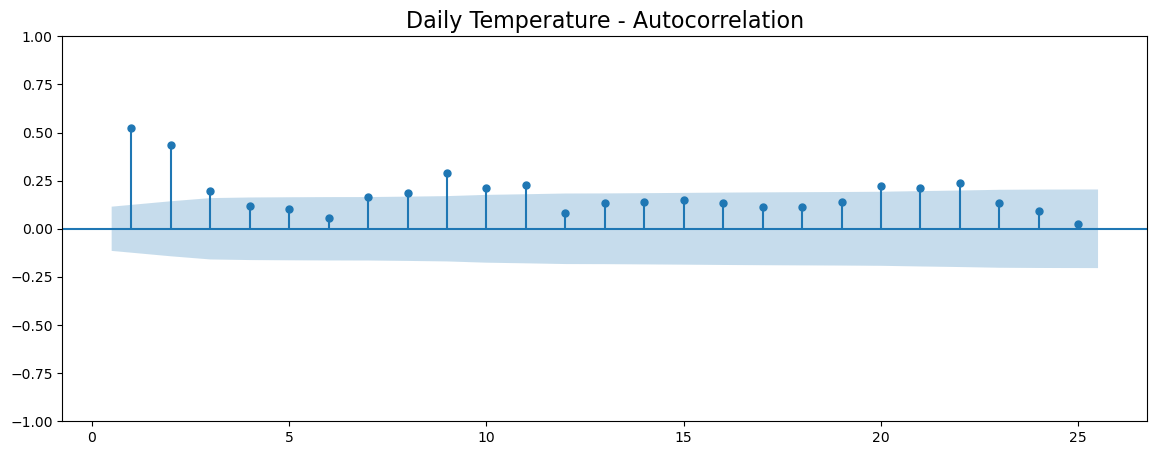

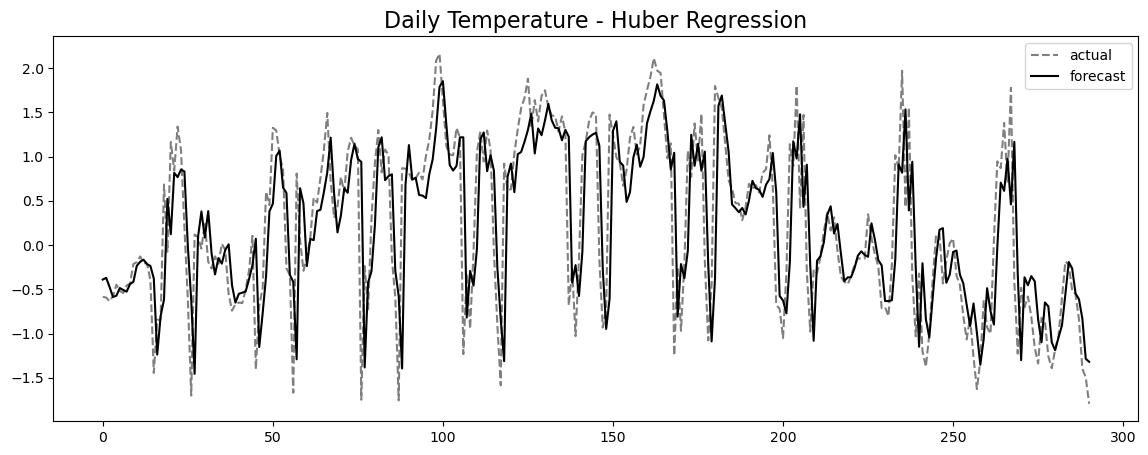

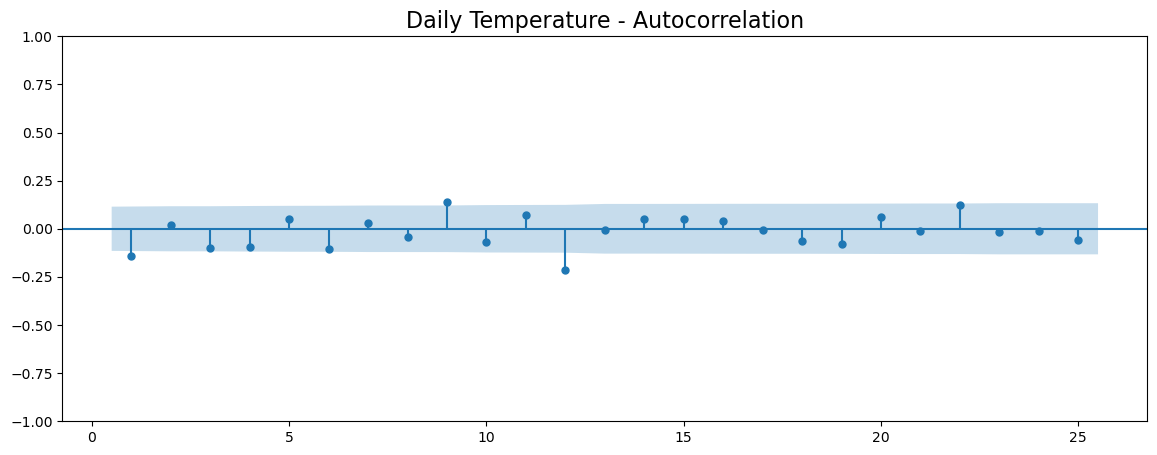

In [17]:
plot_results(cols, dw_results, 'Daily Temperature')

ElasticNet, Lasso and Ridge add regularization (penalization term) to objective function that we want to minimize.

In Lasso (L1) Regression, the regularization term can reduce the coefficient (the βs in the objective function) of the least important features (independent variables) to zero.

Ridge (L2) Regression can shrink the coefficients of the least important features but does not eliminate them (no zero coefficients)

ElasticNet Regression is a hybrid between the two by combining L1 and L2 regularization terms.

In [18]:
cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


#### Energy Consumption

**Regression Coefficients and Feature Selection**

In [19]:
## from above lasso regression results, only 10th feature(lag) is significant
# so train model only on 10th lag

en_10 = en_reg[['y', 'x_10']]

train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)

en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  1.419527  0.525526
2   Ridge Regression  0.433192  1.586383  0.560450
0  Linear Regression  0.433747  1.583406  0.560989
1        Elastic Net  0.747657  1.822362  1.013425
3   Lasso Regression  0.834356  1.548537  1.108092

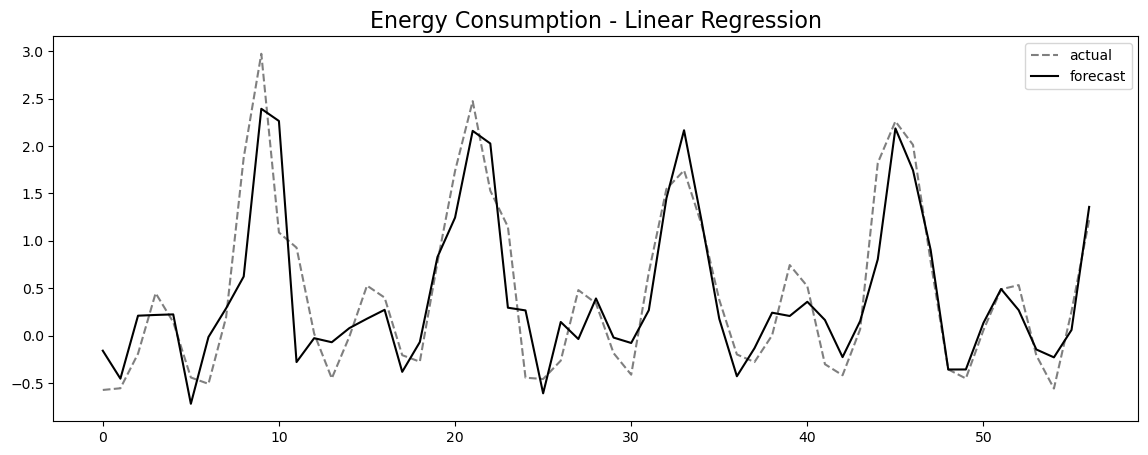

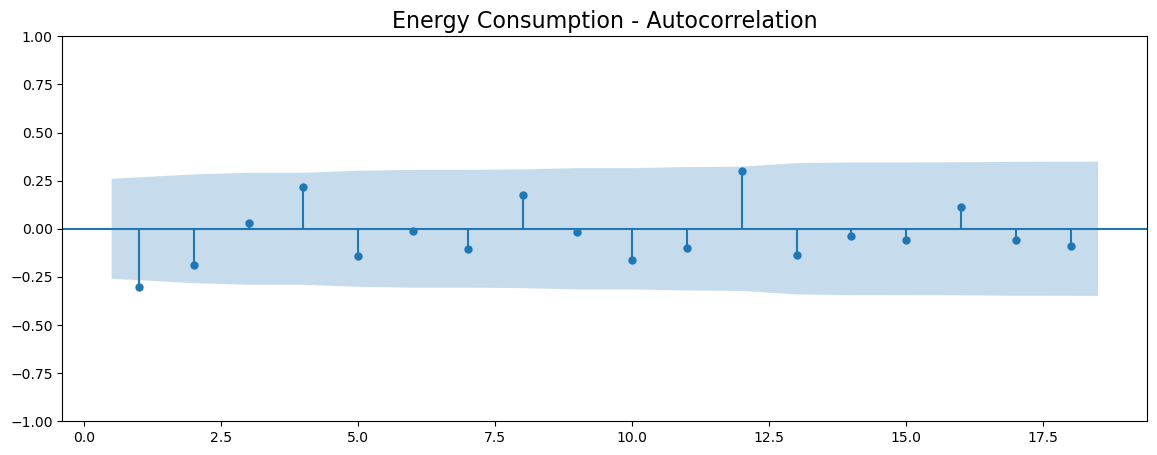

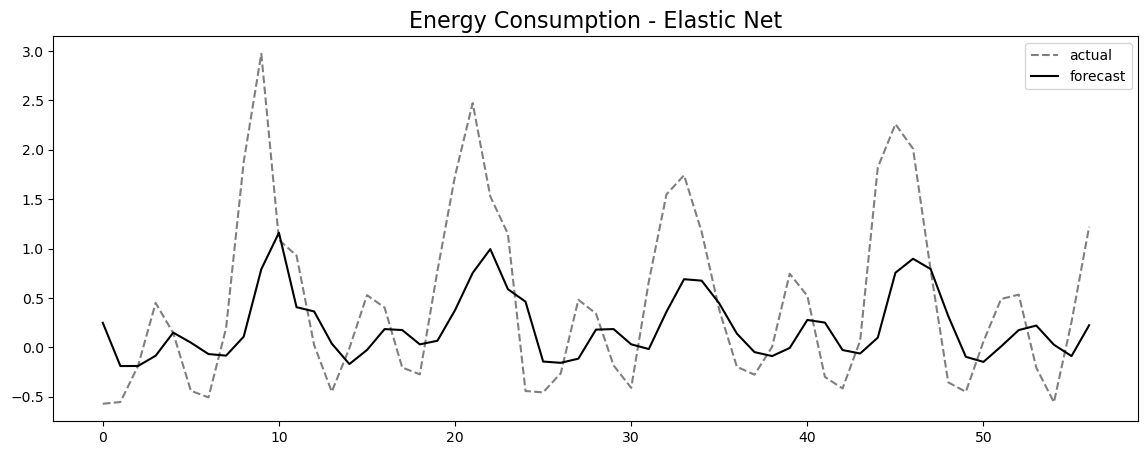

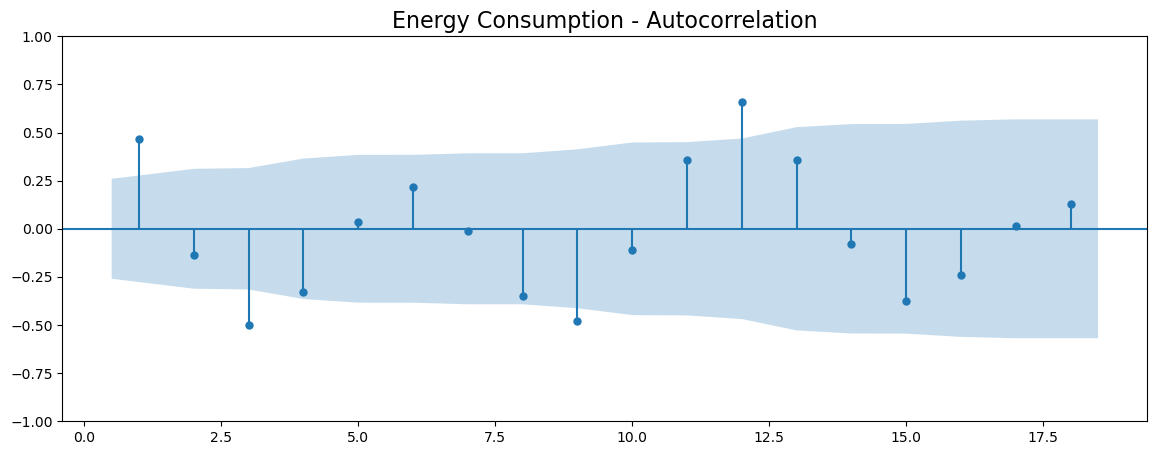

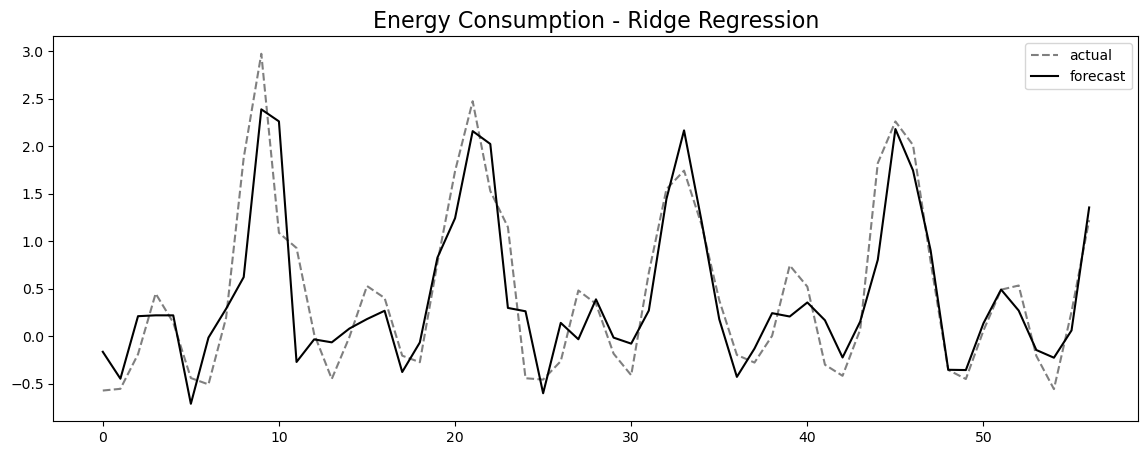

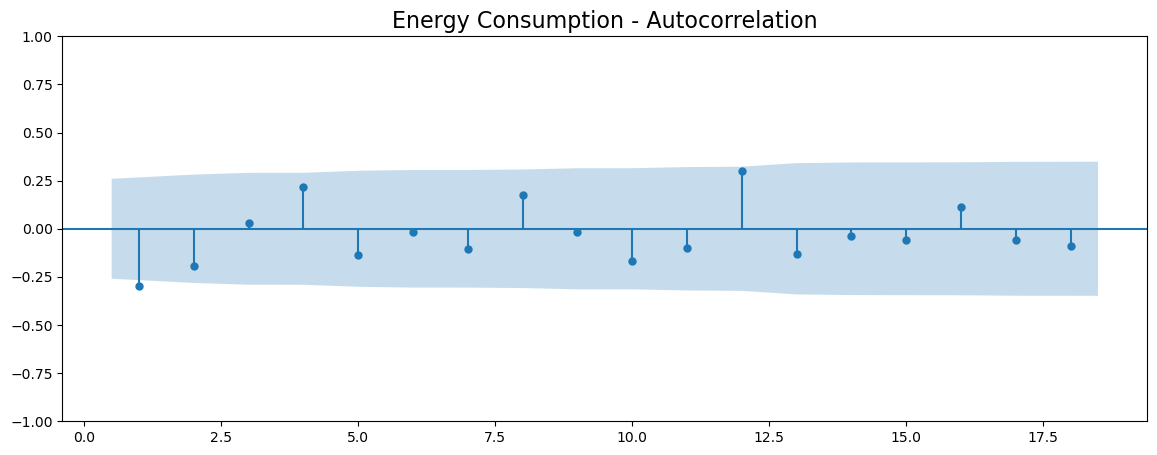

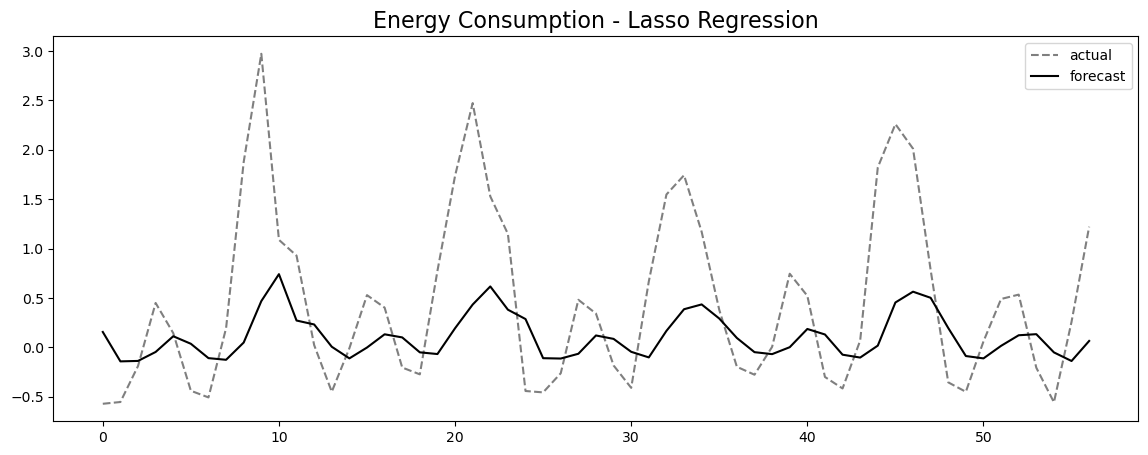

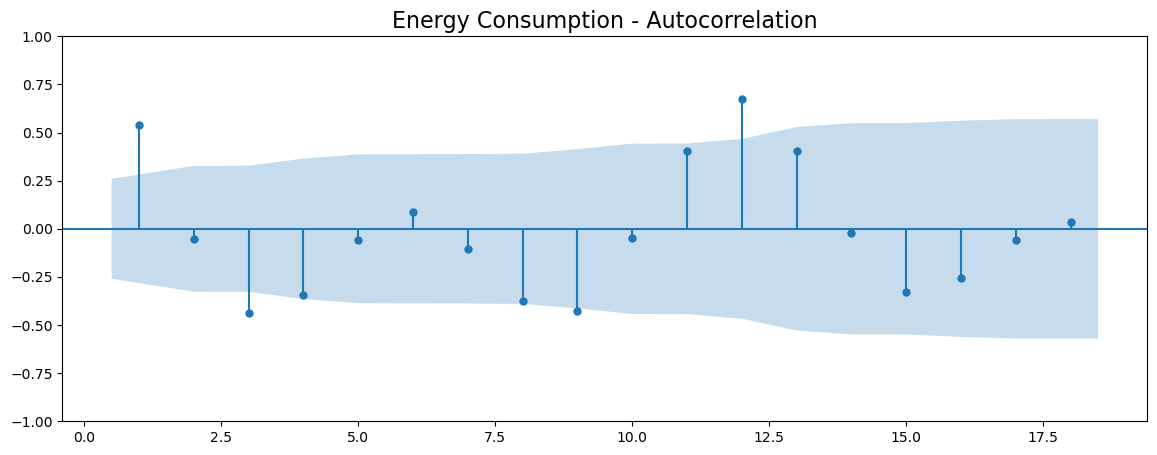

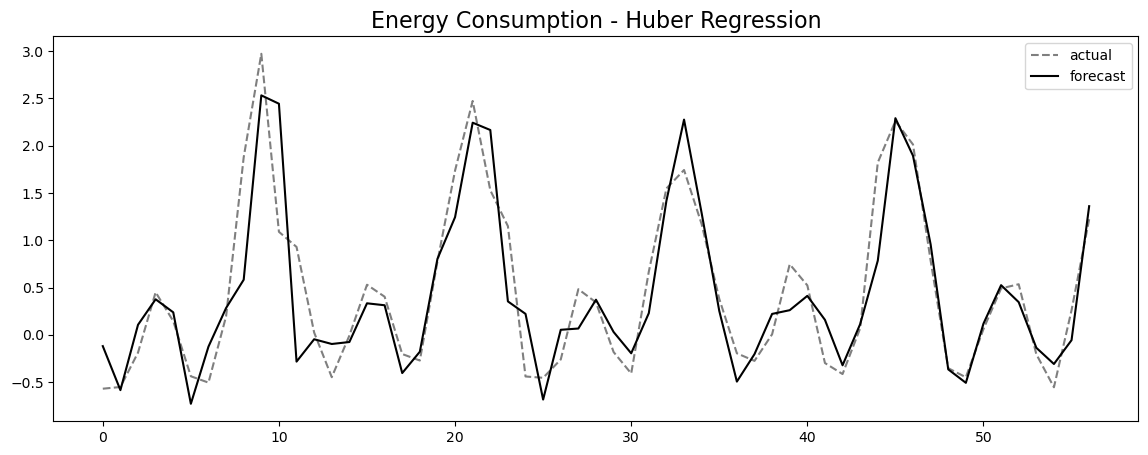

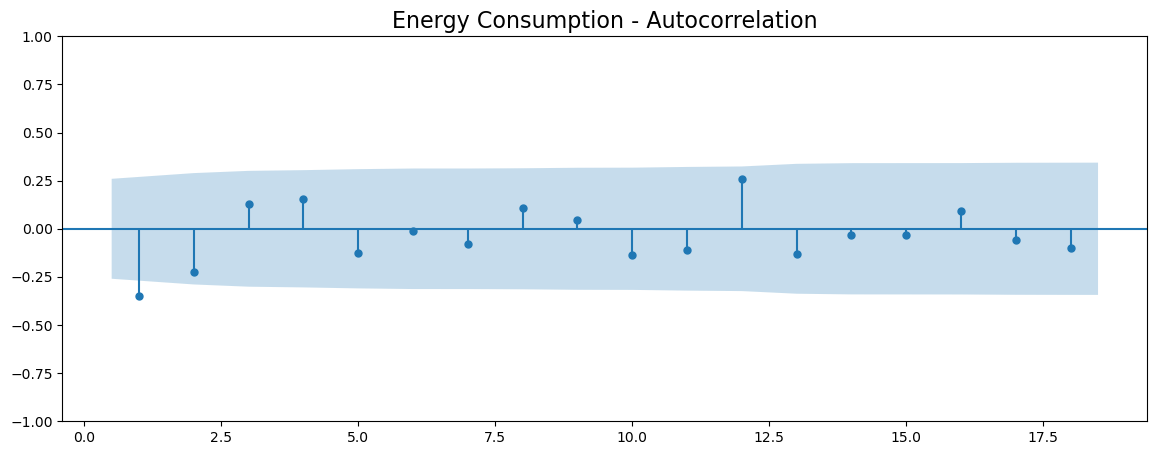

In [20]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_10_results, 'Energy Consumption')
     # its clear that performance of from just 1 feature (lag 10) obtained similar results

In [21]:
cols = ['Model Name', 'Model']
en_models = en_10_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[0.75051783]
Elastic Net
[0.39987585]
Ridge Regression
[0.74979687]
Lasso Regression
[0.24955629]


### Multi-Step Forecasting using Linear Regression Models with Scikit-Learn

In  one-step forecasting, you provide a sequence of values for the past 10 periods (𝑋1,𝑋2, … , 𝑋10) and the linear model will forecast the next period (𝑋11), which is referred to as 𝑌. 

4 stratergies for Multistep forecasting - 
* Recursive Stratergy
* Direct stratergy
* DirRec (Direct-Recursive) stratergy
* Multiple Output Stratergy

The following illustrates the idea behind the **recursive strategy**. It is still based on one-step forecasts that are reused (recursively) to make the next one-step prediction, and the process continues (think of a loop) until you get all the future steps, known as future horizons, produced.

One problem with the recursive strategy is that as you go further into the future, you are exclusively relying on the estimated values and any associated estimation errors

Direct strategy -> which creates multiple models for each future step. Each model produces a one-step forecast, but they act independently. problesm are 
1. This can cause a maintenance issue; for example, to produce a 10-day forecast, you will have 10 models. 
2. this independence is a lost opportunity to capture dependencies that would occur from one prediction to another

DirRec strategy -> is a hybrid of direct and recursive and a way to mitigate their individual shortcomings.

Multiple output strategy-> you will create a similar sliding window function as you 
did with the one_step_forecast function. However, the new function will also take 
an output window.

In [22]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

air_results = pd.DataFrame(air_results)
en_results = pd.DataFrame(en_results)
dw_results = pd.DataFrame(dw_results)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [23]:
dw_results

Model Name                                       Model      RMSE  \
0  Linear Regression       LinearRegression(fit_intercept=False)  0.646648   
1        Elastic Net  ElasticNet(alpha=0.5, fit_intercept=False)  0.737896   
2   Ridge Regression       Ridge(alpha=0.5, fit_intercept=False)  0.646639   
3   Lasso Regression       Lasso(alpha=0.5, fit_intercept=False)  0.814609   
4   Huber Regression         HuberRegressor(fit_intercept=False)  0.655729   

       MAPE      MASE                                               yhat  \
0  1.037424  0.990057  [-0.2961925386523881, -0.3145139435480657, -0....   
1  0.913599  1.300792  [-0.3018190700137878, -0.24968002141505938, -0...   
2  1.037273  0.990085  [-0.29613870275885373, -0.3144177205378608, -0...   
3  0.911730  1.468567  [-0.1768781411197209, -0.14827924485769892, -0...   
4  1.083826  0.968735  [-0.38904409394014283, -0.36999768608750744, -...   

                                               resid  \
0  [-0.288032218288153, -0.278722523215017, -0.19...   
1  [-0.2824056869267533, -0.3435564453480233, -0....   
2  [-0.28808605418168737, -0.2788187462252219, -0...   
3  [-0.4073466158208202, -0.4449572219053838, -0....   
4  [-0.19518066300039827, -0.2232387806755753, -0...   

                                              actual  
0  [-0.5842247569405411, -0.5932364667630827, -0....  
1  [-0.5842247569405411, -0.5932364667630827, -0....  
2  [-0.5842247569405411, -0.5932364667630827, -0....  
3  [-0.5842247569405411, -0.5932364667630827, -0....  
4  [-0.5842247569405411, -0.5932364667630827, -0....

In [24]:
test_dw_s.iloc[[-1]]

x_1       x_2       x_3       x_4       x_5       x_6  \
DateTime                                                                 
2016-12-22 -1.180203 -1.022581 -0.604237 -0.189764 -0.224464 -0.514589   

                 x_7       x_8       x_9      x_10         y  
DateTime                                                      
2016-12-22 -0.559203 -0.839812 -1.397096 -1.496642 -1.792546

In [25]:
models = dw_results[['Model Name','Model']]
models

Model Name                                       Model
0  Linear Regression       LinearRegression(fit_intercept=False)
1        Elastic Net  ElasticNet(alpha=0.5, fit_intercept=False)
2   Ridge Regression       Ridge(alpha=0.5, fit_intercept=False)
3   Lasso Regression       Lasso(alpha=0.5, fit_intercept=False)
4   Huber Regression         HuberRegressor(fit_intercept=False)

In [26]:
def multi_step_forecast(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)

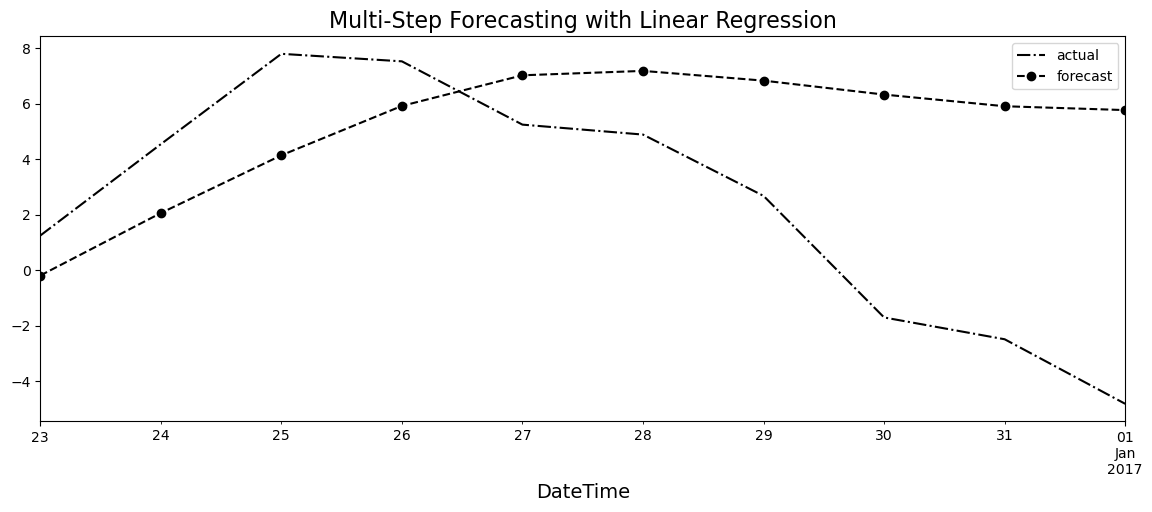

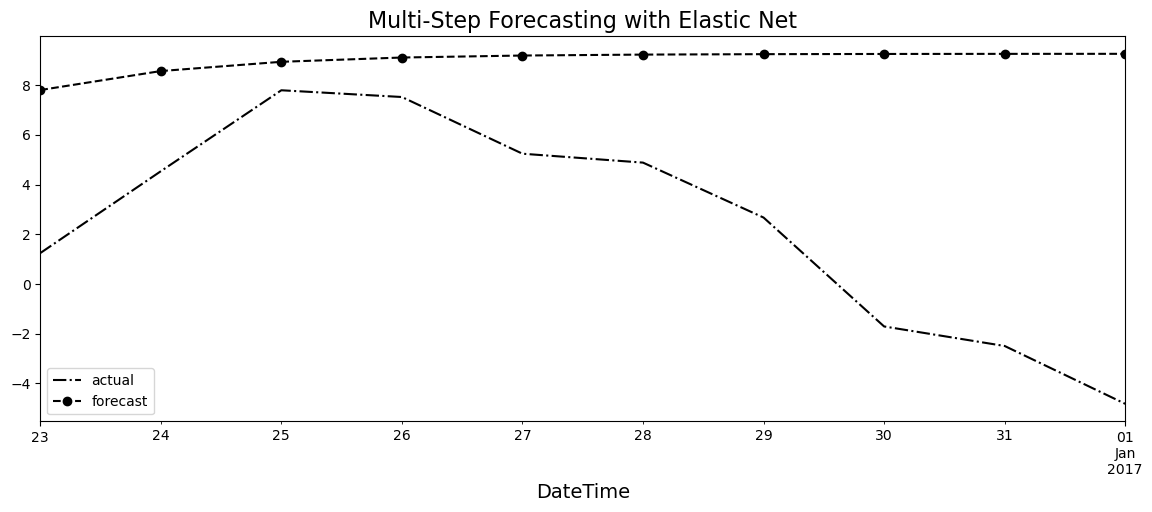

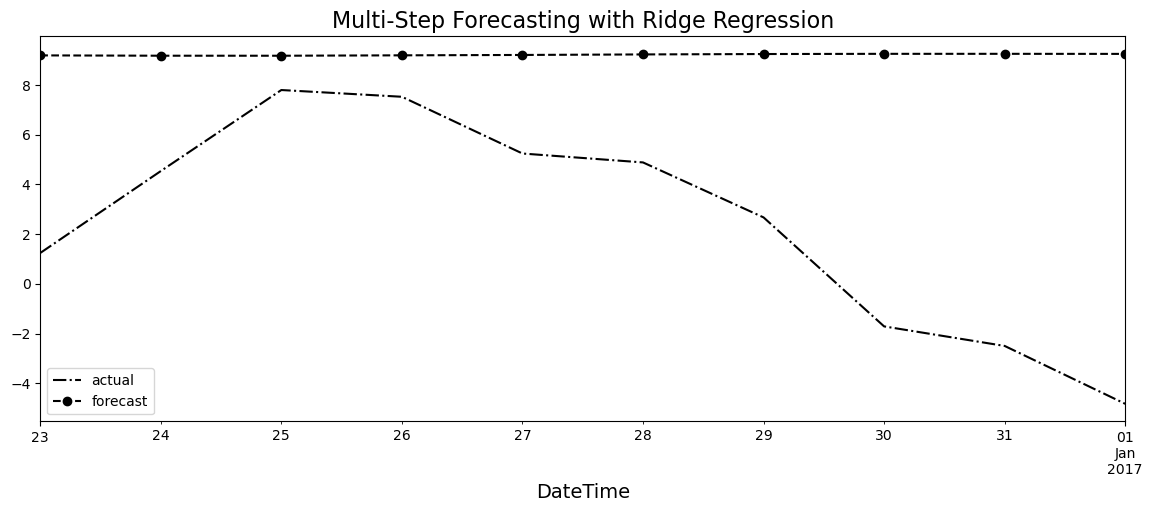

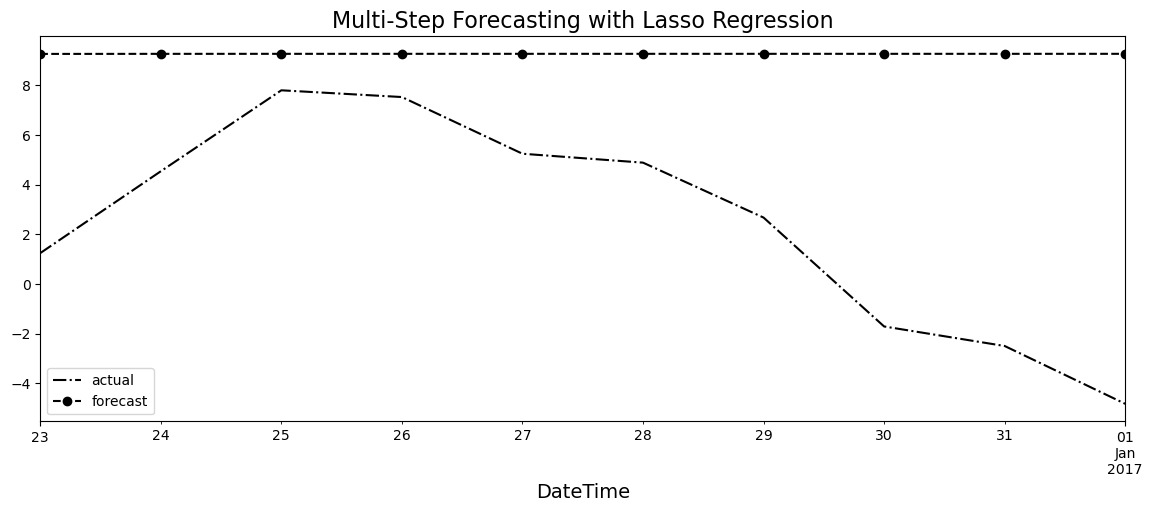

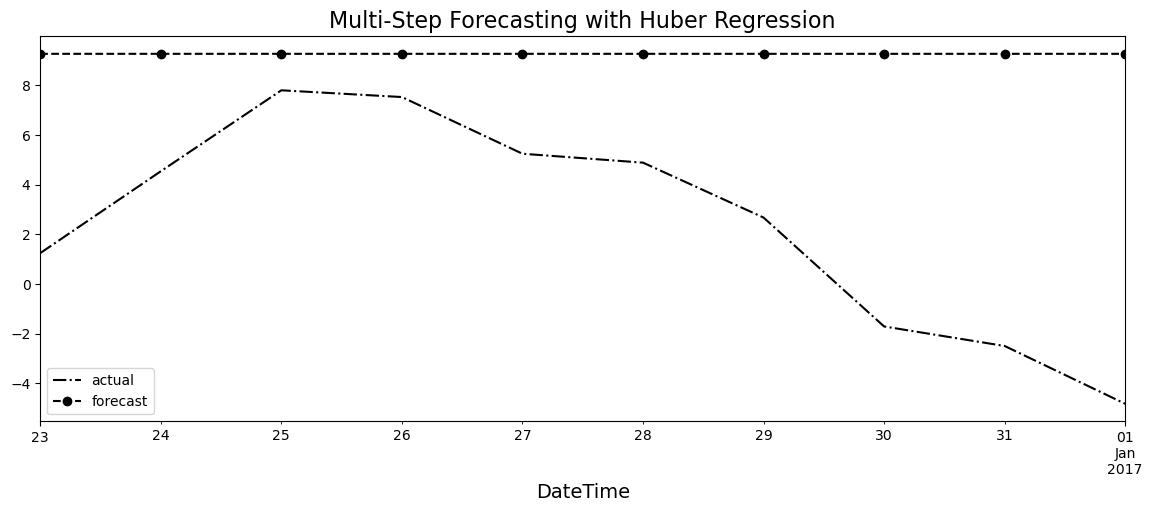

In [28]:
## Air passengers
models = air_results[['Model Name','Model']]
air_ms = test_air.drop(columns=['y']).iloc[-1].tolist()
frcst_air = {}
for i in models.iterrows():
    pred = multi_step_forecast(air_ms, steps=10, model=i[1]['Model'])
    pred = scaler_air.inverse_y(pred)
    frcst_air[i[1]['Model Name']] = pred   

## Energy consumption
models = en_results[['Model Name','Model']]
en_ms = test_en_s.drop(columns=['y']).iloc[-1].tolist()
frcst_en = {}
for i in models.iterrows():
    pred = multi_step_forecast(en_ms, steps=10, model=i[1]['Model'])
    pred = scaler_en.inverse_y(pred)
    frcst_en[i[1]['Model Name']] = pred   

## Daily Temperature
frcst_dw = {}
models = dw_results[['Model Name','Model']]
dw_ms = test_dw_s.drop(columns=['y']).iloc[-1].tolist()

for i in models.iterrows():
    pred = multi_step_forecast(dw_ms, steps=10, model=i[1]['Model'])
    pred = scaler_dw.inverse_y(pred)
    frcst_dw[i[1]['Model Name']] = pred  

#### Example on Daily Temperature Data
for name, pred in frcst_dw.items():
    actual = dw_cp.iloc[-10:]
    ax = actual.plot(style='k-.')
    pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
    plt.title(f'Multi-Step Forecasting with {name}')
    plt.legend(['actual', 'forecast'])
    plt.show()

#### Multiple Output Stratergy

2913
Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10'],
      dtype='object')
(2614, 20)
(20,)


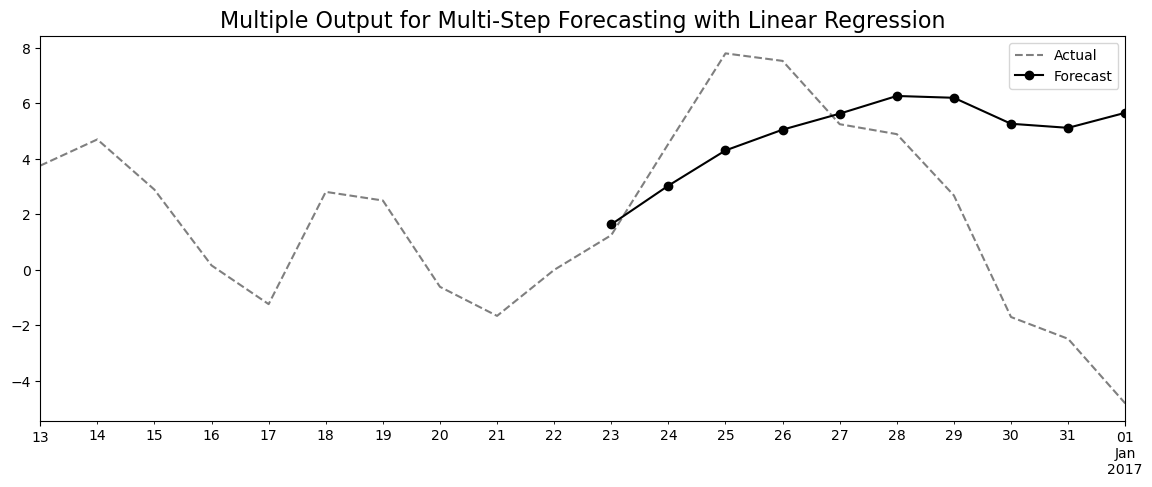

In [29]:
def multiple_output(df, window_in, window_out):
    # a window_in parameter for the number of features to be generated
    # a window_out parameter for the number of target variables to be generated
    d = df.values       
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    print(len(idx))
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

win_in, win_out = 10, 10
dw_mo = multiple_output(dw_cp, win_in, win_out)

train_dw, test_dw = split_data(dw_mo, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

print(dw_mo.columns)
print(train_dw_s.shape)

lr = LinearRegression()

X_train, y_train = train_dw_s.iloc[: , :win_in], train_dw_s.iloc[:, win_out:]
X_test, y_test = test_dw_s.iloc[: , :win_in], test_dw_s.iloc[:, win_out:]


lr.fit(X_train, y_train)

mo_pred = scaler_dw.inverse_y(lr.predict(X_test)[-1])
dates = pd.date_range('2016-12-13', freq='D', periods=20)
inputs, outputs = dates[:win_in], dates[win_out:]

print(test_dw.iloc[-1].values.shape)


pd.Series(test_dw.iloc[-1].values, index=dates).plot(style='k--', alpha=0.5)
pd.Series(mo_pred, index=outputs).plot(style='k-o')
plt.title('Multiple Output for Multi-Step Forecasting with Linear Regression')
plt.legend(['Actual', 'Forecast'])

### Forecasting using Non-Linear Models with sktime

sktime is a unified machine learning framework for time series


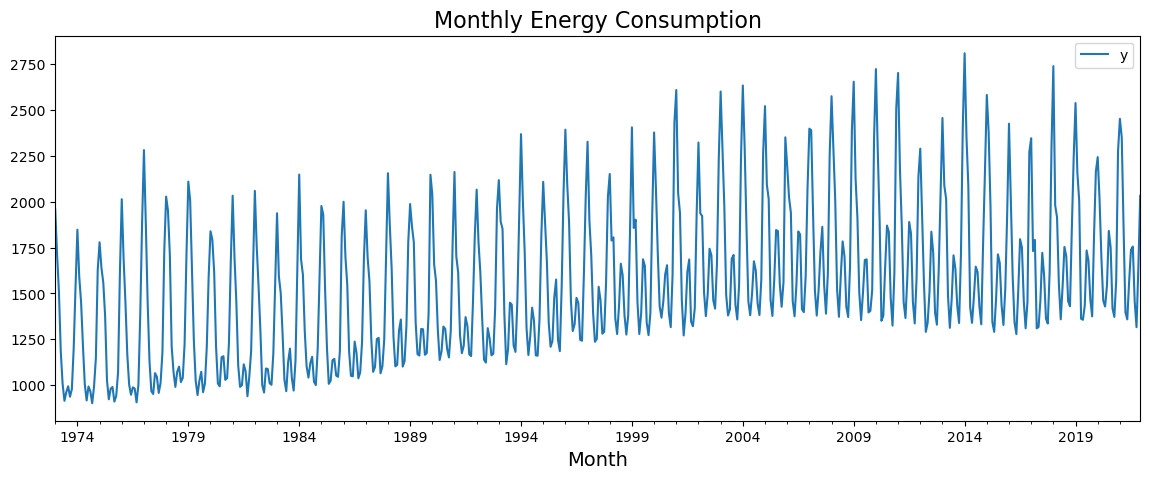

In [30]:
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import sktime
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction


df = energy.copy()

df.plot(title='Monthly Energy Consumption');plt.show()

(500, 1)
(88, 1)


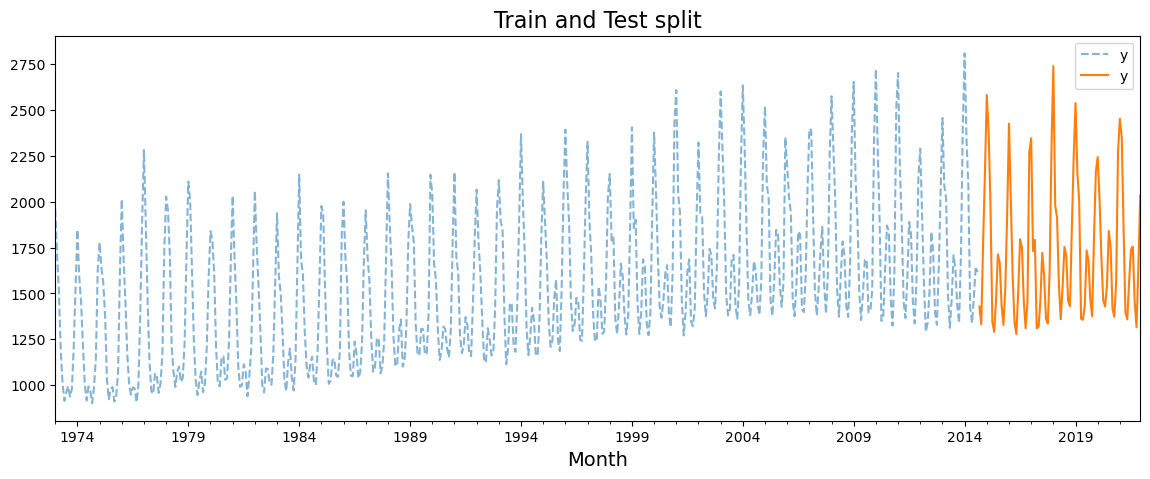

In [31]:
train, test = split_data(df)

print(train.shape)
print(test.shape)

ax = train.plot(style='--', alpha=0.55)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

(-1.4497331132437465, 0.5582151234544193, 12, 575, {'1%': -3.4417738839904657, '5%': -2.8665796253604015, '10%': -2.569453974291115}, 6916.6482184861825)


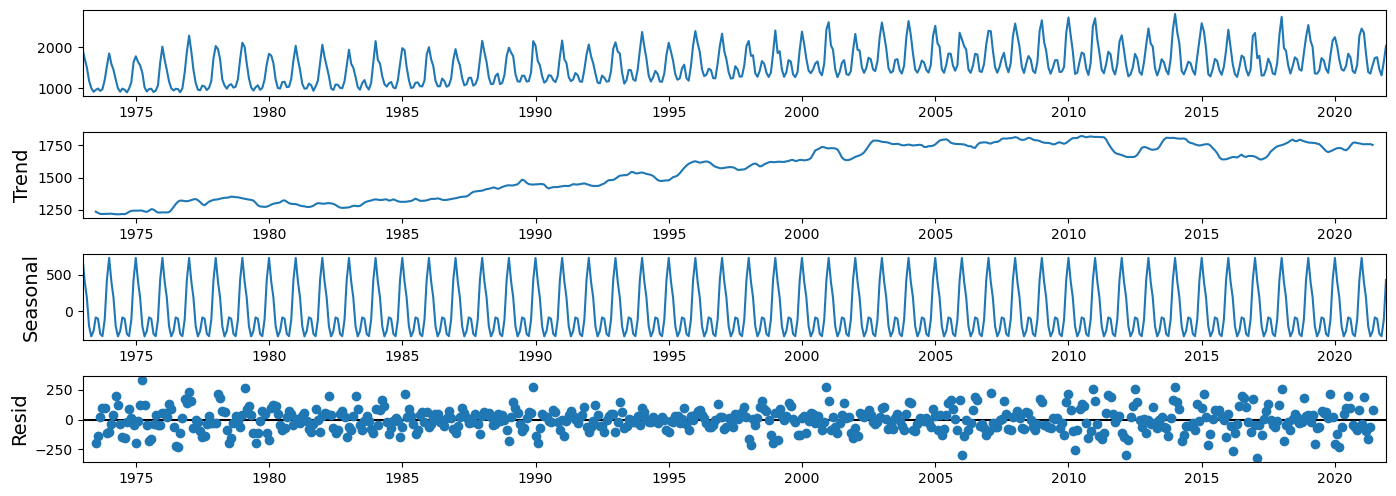

In [32]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

print(adfuller(df))

decomposed = seasonal_decompose(df)
decomposed.plot();

In [34]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor, # ML estimator
            strategy='recursive', # direct, recursive or multioutput -> multi-step forecasting
            window_length=window, # sliding window length
            scitype='tabular-regressor')) # scientific type -> infer, tabular-regressor,
                                           # or time-series-regressor
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
           #TransformedTargetForecaster allowed you to create a chain of steps, 
           # a pipeline, to transform the time series for 3 transformation
           # Deseasonalizer class, Detrender class and make_reduction function
    else:
        model = regressor.fit(data.values)
    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [39]:
make_reduction(lr) # this creates reduced regression for time series
       # make_reduction will return a RecursiveTabularRegressionForecaster class, 
       # and the default strategy parameter is recursive

RecursiveTabularRegressionForecaster(estimator=LinearRegression())

In [36]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12), # base model
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor': ExtraTreesRegressor(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

training NaiveForecaster(sp=12, strategy='mean') ...
training LinearRegression() ...
training KNeighborsRegressor() ...
training ExtraTreesRegressor() ...
training RandomForestRegressor() ...
training GradientBoostingRegressor() ...


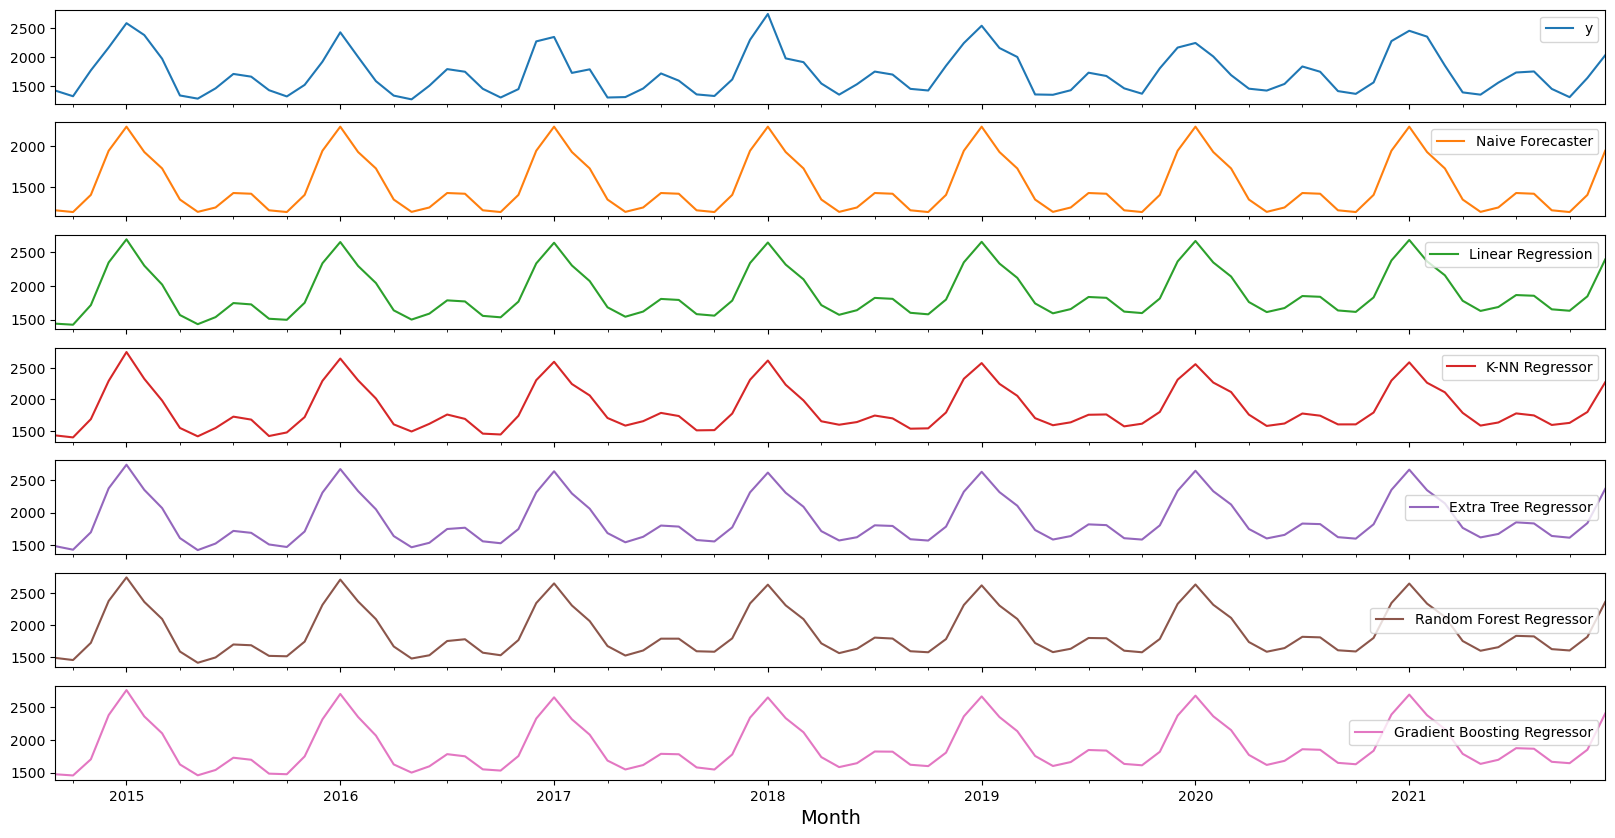

In [37]:
test.plot(subplots=True, figsize=(20, 10));plt.show();

<AxesSubplot:xlabel='Month'>

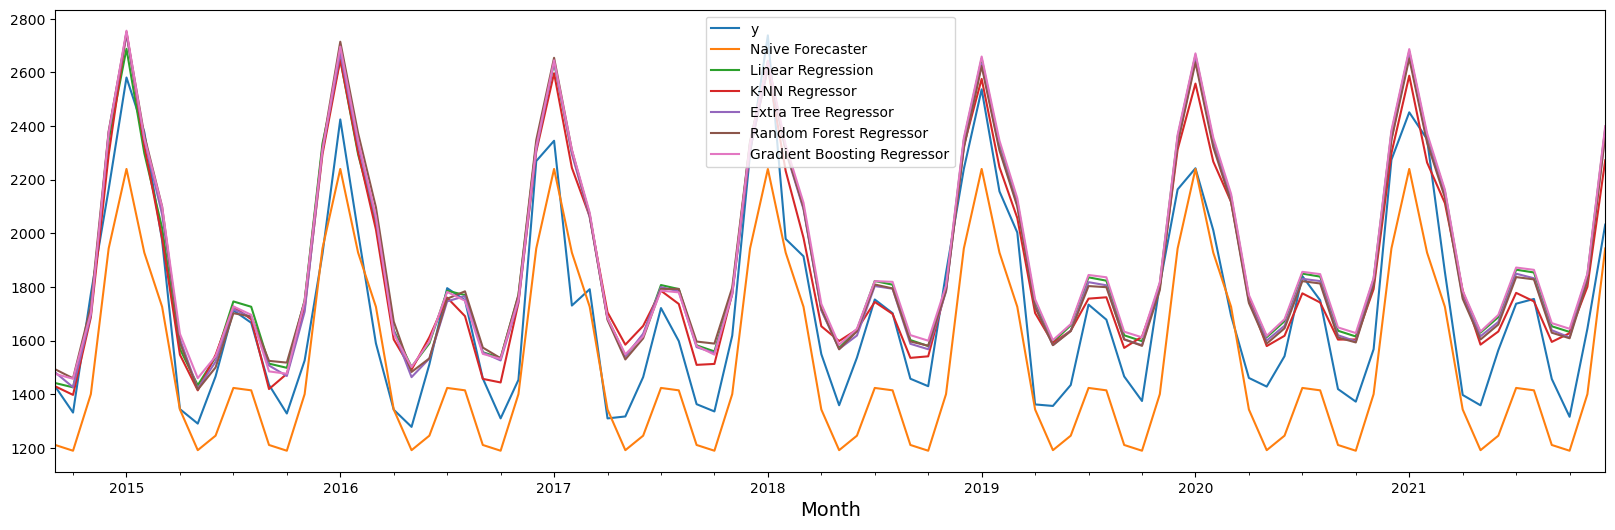

In [40]:
test.plot(subplots=False, figsize=(20, 6))

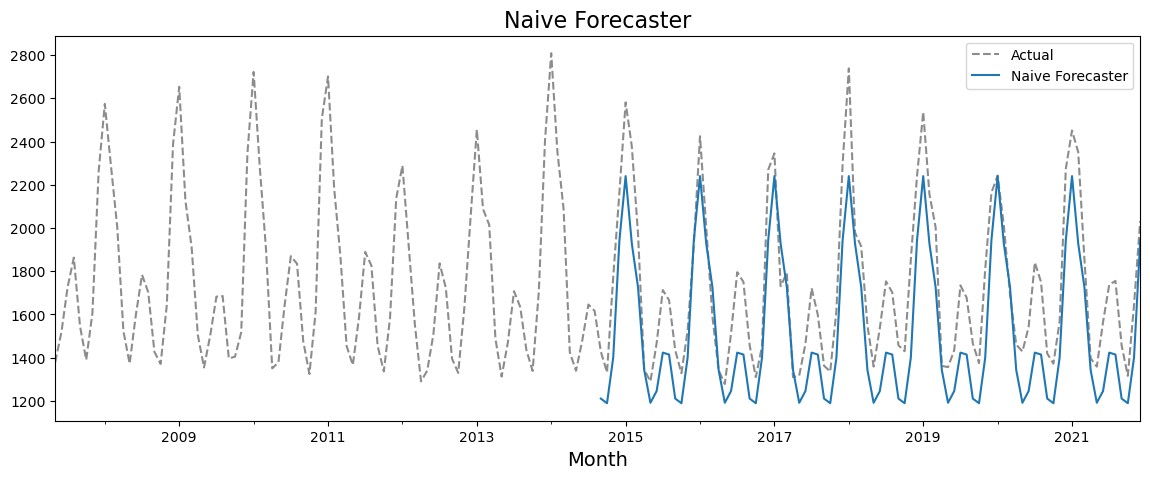

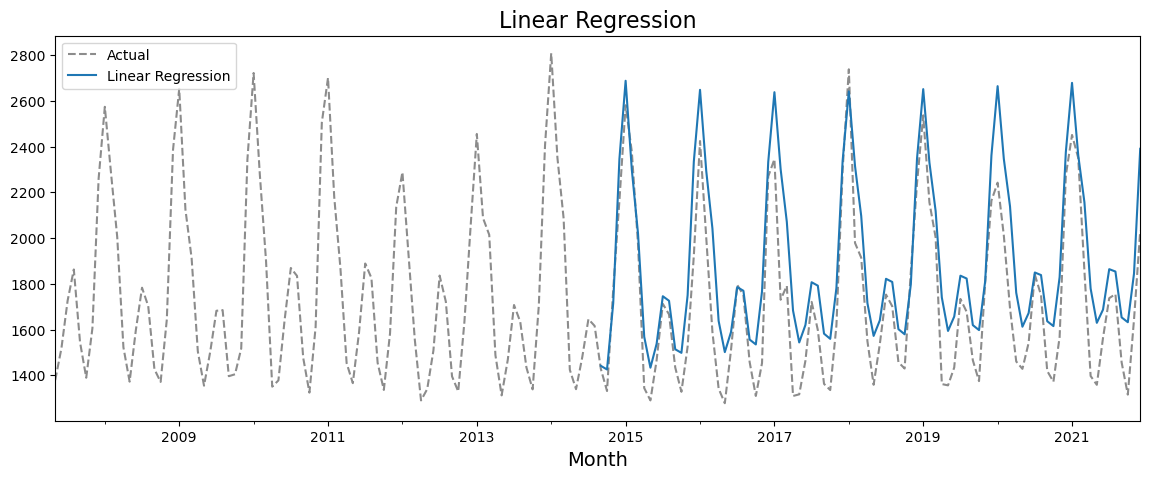

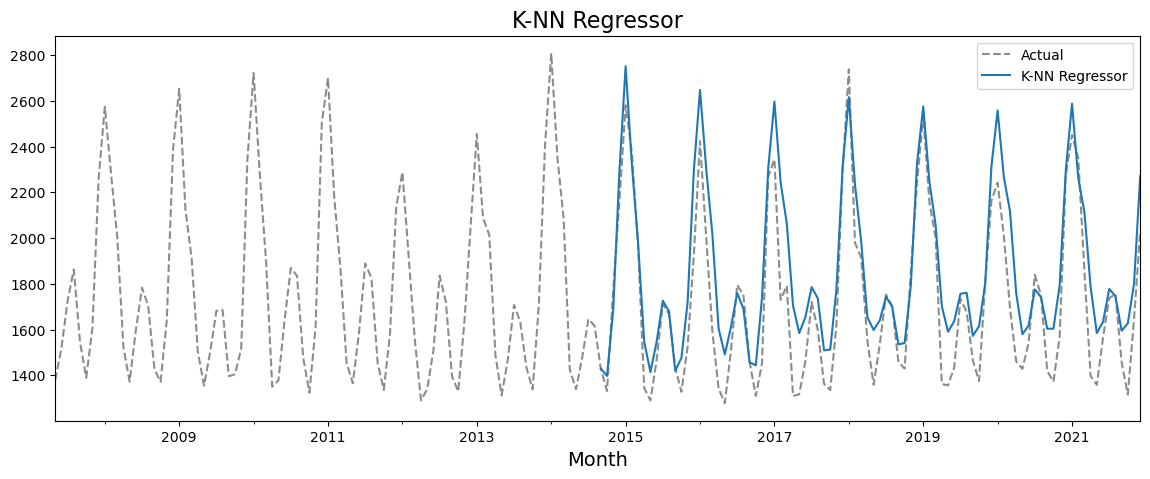

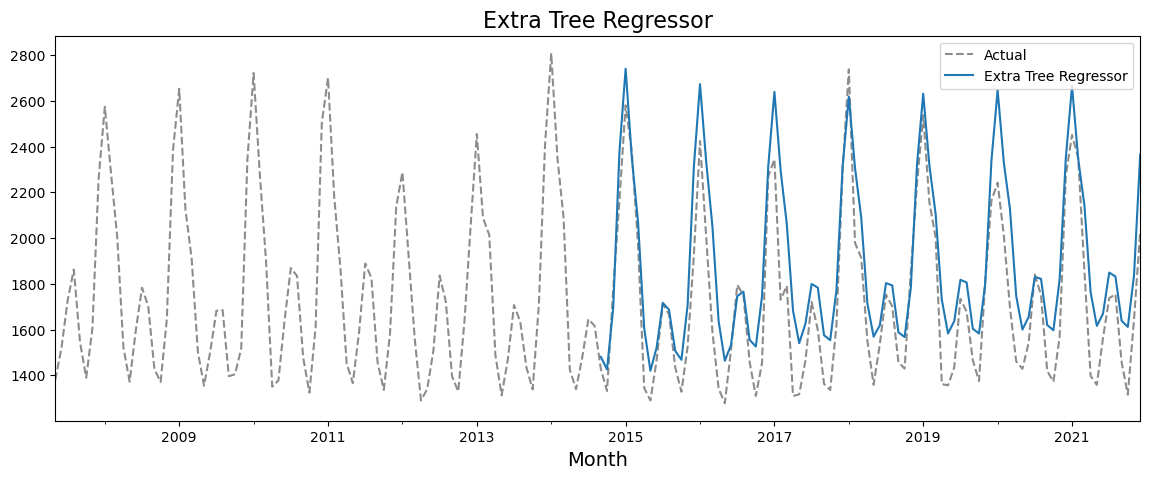

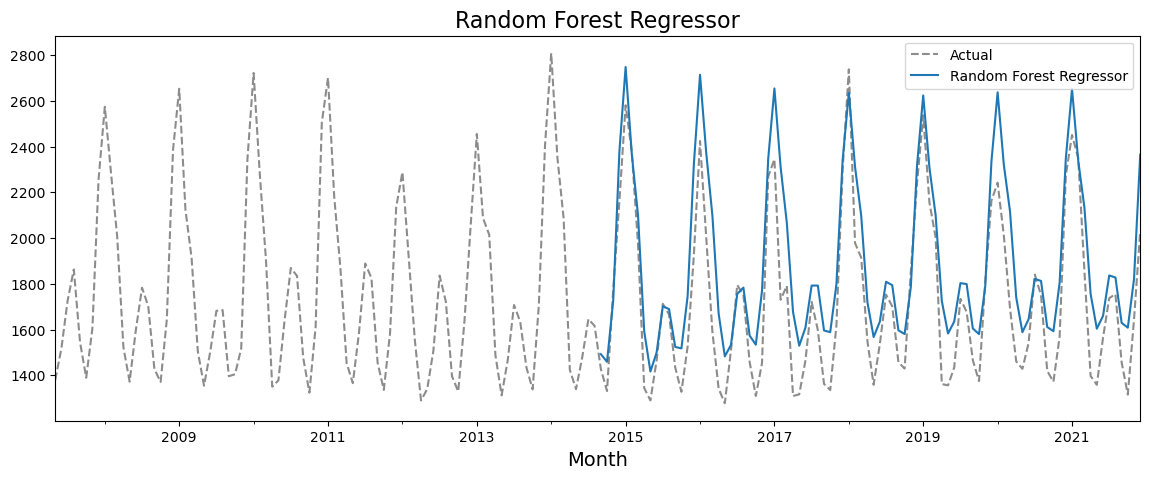

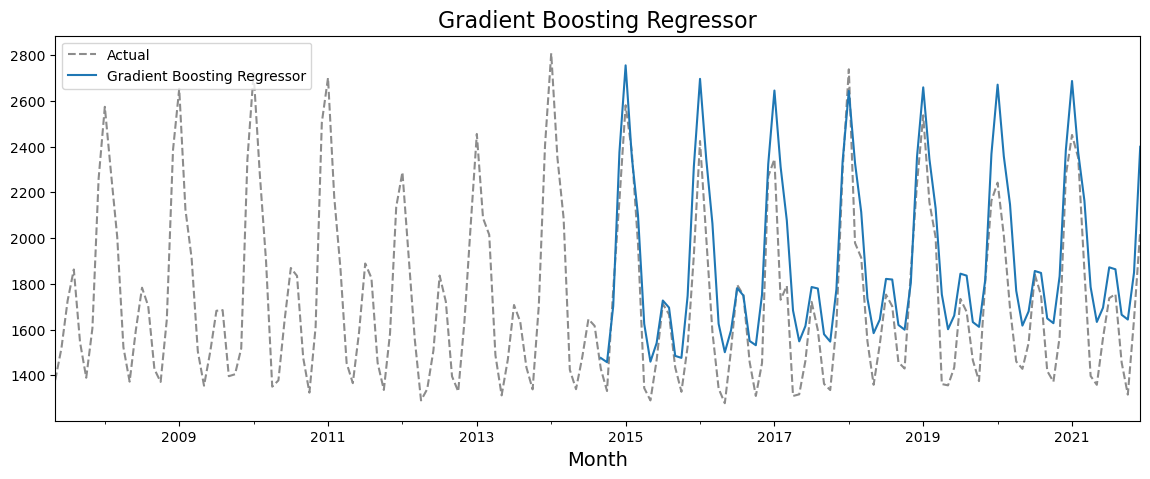

In [41]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [42]:
def evaluate(df, train, sort_by='MASE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['y']
    y_predicted = df.drop(columns=['y'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
        evals.loc['MASE', p] = mase(y_truth, y_predicted[p], y_train=train)
    return evals.T.sort_values(by=sort_by)

evaluate(test, train)
         ## KNN Regressor performed best followed by Extra trees. both captures non-linearity

sMAPE      MAPE        RMSE      MASE
K-NN Regressor               0.088718  0.095485  192.449319  0.685551
Extra Tree Regressor         0.100690  0.108579  211.713803  0.788891
Random Forest Regressor      0.102779  0.111015  216.145837  0.806177
Linear Regression            0.105661  0.114187  219.063673  0.828132
Gradient Boosting Regressor  0.109244  0.118286  226.479919  0.859982
Naive Forecaster             0.133619  0.123643  242.222293  0.957688

In [43]:
evaluate(test, train, sort_by='RMSE')

sMAPE      MAPE        RMSE      MASE
K-NN Regressor               0.088718  0.095485  192.449319  0.685551
Extra Tree Regressor         0.100690  0.108579  211.713803  0.788891
Random Forest Regressor      0.102779  0.111015  216.145837  0.806177
Linear Regression            0.105661  0.114187  219.063673  0.828132
Gradient Boosting Regressor  0.109244  0.118286  226.479919  0.859982
Naive Forecaster             0.133619  0.123643  242.222293  0.957688

#### compare ML regressors with ARIMA model

In [44]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2988.064
Date:                            Mon, 14 Nov 2022   AIC                           5984.127
Time:                                    23:46:59   BIC                           6000.978
Sample:                                         0   HQIC                          5990.740
                                            - 500                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4295      0.037    -11.724      0.000      -0.501      -0.358
ar.S.L12       0.9982      0.001    729.537      0.000       0.996       1.001
ma.S.L12      -0.7859      0.030    -26.582      0.000      -0.844      -0.728
sigma2      8549.9827    415.371     20.584      0.000    7735.870    9364.095
===================================================================================
Ljung-Box (L1) (Q):                   9.08   Jarque-Bera (JB):                70.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(88, 8)


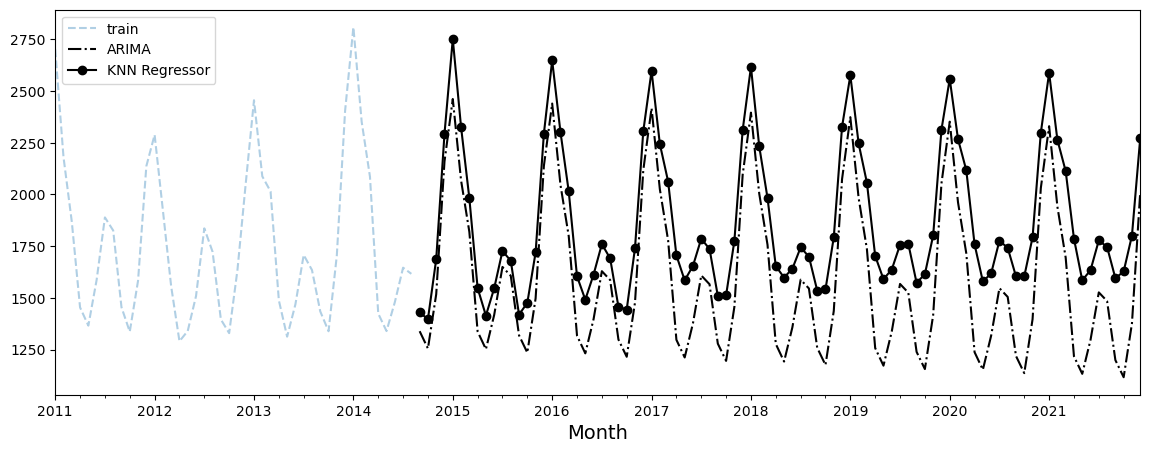

In [45]:
test['ARIMA'] = arima.predict(n)

print(test.shape)

evaluate(test, train)

ax = train.loc['2011':].plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k-.')
test['K-NN Regressor'].plot(ax=ax, style='k-o')
# test['Naive Forecaster'].plot(ax=ax, style='.-')
plt.legend(['train', 'ARIMA', 'KNN Regressor'])

'''
The ARIMA model did a decent job overall compared to more advanced ML regressors. 
This is sometimes the case with smaller univariate time series. 
Keep in mind that the ML models (regressors) are not optimized yet 
(via hyperparameter tuning) while the ARIMA model was optimized by auto_arima 
to find the best hyperparameters (the seasonal and non-seasonal orders). 
ML algorithms are great for working with more complex multivariate 
time series data
'''

### Optimizing a Machine Learning model with Hyperparameter Tuning

In [46]:
from sktime.forecasting.all import (
        ForecastingGridSearchCV, 
        SlidingWindowSplitter,
        MeanAbsolutePercentageError)

## Build KNN Regressor and improve it with hyper parameters tuning
df = energy.copy()
train, test = split_data(df)
print(test.shape)

# TransformedTargetForecaster class to create a pipeline for transforming timeseries
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ("forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ), ),  ])

# fit model
forecaster.fit(train.values)
# predict values
test['KNN-Regressor'] = forecaster.predict(fh)

# Evaluate models
evaluate(test, train)


(88, 1)


sMAPE      MAPE        RMSE      MASE
KNN-Regressor  0.090378  0.097746  225.568315  0.751772

In [47]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__algorithm': 'auto',
 'forecast__estimator__leaf_size': 30,
 'forecast__estimator__metric': 'minkowski',
 'forecast__estimator__metric_params': None,
 'forecast__estimator__n

In [48]:
# example grid search space
hyperparams_grid = {
    "forecast__estimator__n_neighbors": [i for i in range(3,11)],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__p": [1,2]
}

# for cross-validation using SlidingWindowSplitter -> slides over one step at 
# each iteration, # keeping the training and test fold sizes constant
cv = SlidingWindowSplitter(window_length=int(len(df) * 0.70), fh=fh) 
# Scoring for evaluating models
smape = MeanAbsolutePercentageError(symmetric=True)

# Grid search cv to try all combinations and provide scores
grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv,
    param_grid=hyperparams_grid, 
    scoring=smape,
    return_n_best_forecasters=1,
    verbose=1 # to print summary
)

grid_csv.fit(train.values, fh=fh)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relat...
                                                                       Detrender(forecaster=PolynomialTrendForecaster())),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                                                                                            window_length=12))]),
                        param_grid={'deseasonalize__model': ['multiplicative',
                                                             'additive'],
                                    'forecast__estimator__n_neighbors': [3, 4,
                                                                         5, 6,
                                                                         7, 8,
                                                                         9,
                                                                         10],
                                    'forecast__estimator__p': [1, 2]},
                        scoring=MeanAbsolutePercentageError(symmetric=True),
                        verbose=1)

In [49]:
grid_csv.best_forecaster_

TransformedTargetForecaster(steps=[('deseasonalize', Deseasonalizer(sp=12)),
                                   ('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                                                         window_length=12))])

In [50]:
grid_csv.best_params_

{'deseasonalize__model': 'additive',
 'forecast__estimator__n_neighbors': 7,
 'forecast__estimator__p': 2}

In [51]:
grid_csv.cv_results_

mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                0.068065       0.015529        0.019092   
1                                0.066450       0.014438        0.021477   
2                                0.065952       0.011242        0.018471   
3                                0.064853       0.016032        0.019431   
4                                0.064658       0.012439        0.018966   
5                                0.062486       0.012474        0.018310   
6                                0.064220       0.012179        0.019161   
7                                0.065216       0.015671        0.020089   
8                                0.066626       0.013875        0.020179   
9                                0.065606       0.014721        0.020891   
10                               0.065828       0.015566        0.020369   
11                               0.066243       0.014090        0.021545   
12                               0.067104       0.015161        0.020731   
13                               0.065111       0.015949        0.021245   
14                               0.066061       0.014083        0.021407   
15                               0.066096       0.017371        0.037248   
16                               0.068791       0.013402        0.018265   
17                               0.063391       0.011828        0.017783   
18                               0.065888       0.012662        0.016955   
19                               0.062623       0.012444        0.017195   
20                               0.064386       0.012060        0.017085   
21                               0.066547       0.012304        0.016595   
22                               0.068606       0.011434        0.016828   
23                               0.066154       0.011885        0.017447   
24                               0.069438       0.013015        0.017497   
25                               0.062401       0.012058        0.017815   
26                               0.065195       0.012175        0.019227   
27                               0.062890       0.013551        0.019350   
28                               0.068173       0.012731        0.020201   
29                               0.063770       0.012767        0.019855   
30                               0.065876       0.015312        0.019686   
31                               0.064710       0.015097        0.019453   

                                               params  \
0   {'deseasonalize__model': 'multiplicative', 'fo...   
1   {'deseasonalize__model': 'multiplicative', 'fo...   
2   {'deseasonalize__model': 'multiplicative', 'fo...   
3   {'deseasonalize__model': 'multiplicative', 'fo...   
4   {'deseasonalize__model': 'multiplicative', 'fo...   
5   {'deseasonalize__model': 'multiplicative', 'fo...   
6   {'deseasonalize__model': 'multiplicative', 'fo...   
7   {'deseasonalize__model': 'multiplicative', 'fo...   
8   {'deseasonalize__model': 'multiplicative', 'fo...   
9   {'deseasonalize__model': 'multiplicative', 'fo...   
10  {'deseasonalize__model': 'multiplicative', 'fo...   
11  {'deseasonalize__model': 'multiplicative', 'fo...   
12  {'deseasonalize__model': 'multiplicative', 'fo...   
13  {'deseasonalize__model': 'multiplicative', 'fo...   
14  {'deseasonalize__model': 'multiplicative', 'fo...   
15  {'deseasonalize__model': 'multiplicative', 'fo...   
16  {'deseasonalize__model': 'additive', 'forecast...   
17  {'deseasonalize__model': 'additive', 'forecast...   
18  {'deseasonalize__model': 'additive', 'forecast...   
19  {'deseasonalize__model': 'additive', 'forecast...   
20  {'deseasonalize__model': 'additive', 'forecast...   
21  {'deseasonalize__model': 'additive', 'forecast...   
22  {'deseasonalize__model': 'additive', 'forecast...   
23  {'deseasonalize__model': 'additive', 'forecast...   
24  {'deseasonalize__model': 'additive', 'forecast...   
25  {'deseaso

In [52]:
test['KNN_optimized'] = grid_csv.predict(fh)

evaluate(test, train)
      ## the optimized K-NN regression did outperform the 
      # standard model with default values.


sMAPE      MAPE        RMSE      MASE
KNN_optimized  0.088823  0.095325  188.102334  0.684741
KNN-Regressor  0.090378  0.097746  225.568315  0.751772

In [53]:
model = grid_csv.best_forecaster_
model.get_params() 

{'steps': [('deseasonalize', Deseasonalizer(sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                      window_length=12),
 'deseasonalize__model': 'additive',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__algorithm': 'auto',
 'forecast__estimator__leaf_size': 30,
 'forecast__estimator__metric': 'minkowski',
 'forecast__estimator__metric_params': None,
 'forecast__estimator__n_jobs': None,
 'forecast__es

### Forecasting with Exogenous variables and Ensemble learning

EnsembleForecaster class takes in a list of multiple regressors, each regressor gets trained, and collectively contribute in making a prediction.

The EnsembleForecaster class from sktime is similar to the VotingRegressor
class in sklearn. Both are ensemble estimators that fit (train) several regressors 
and collectively, they produce a prediction through an aggregate function.

The AutoEnsembleForecaster class in sktime behaves similar to the 
EnsembleForecaster but The difference is that the AutoEnsembleForecaster class will calculate the optimal weights for each of the regressors (i.e. all regressors are  not treated equally)


(203, 12)
(203, 5)


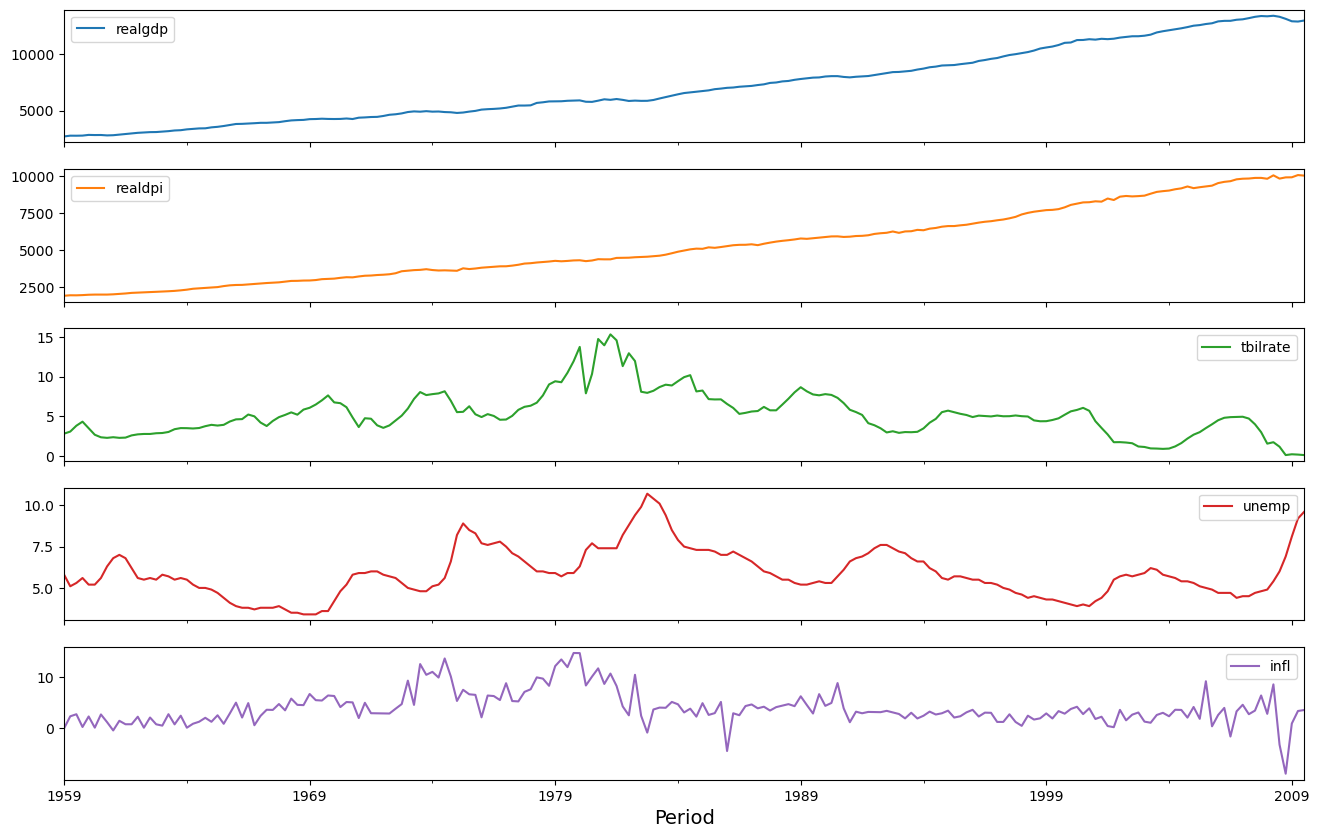

In [54]:
from sktime.forecasting.all import EnsembleForecaster
from sklearn.svm import SVR
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic


print(load_macroeconomic().shape)

econ = load_macroeconomic()
       # predict unemployment using exogenous variabels like inflation, treasury bill rate etc.
       # This is different from the VAR model which is used with 
       # multivariate time series and treats the variables as endogenous variables.
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]

print(econ_df.shape)

econ_df.plot(subplots=True, figsize=(16, 10));plt.show()

                       sMAPE      MAPE      RMSE      MASE
NaiveForecaster     0.946033  2.490779  1.537844  4.522654
EnsembleForecaster  1.281749  1.170122  1.369023  4.616572


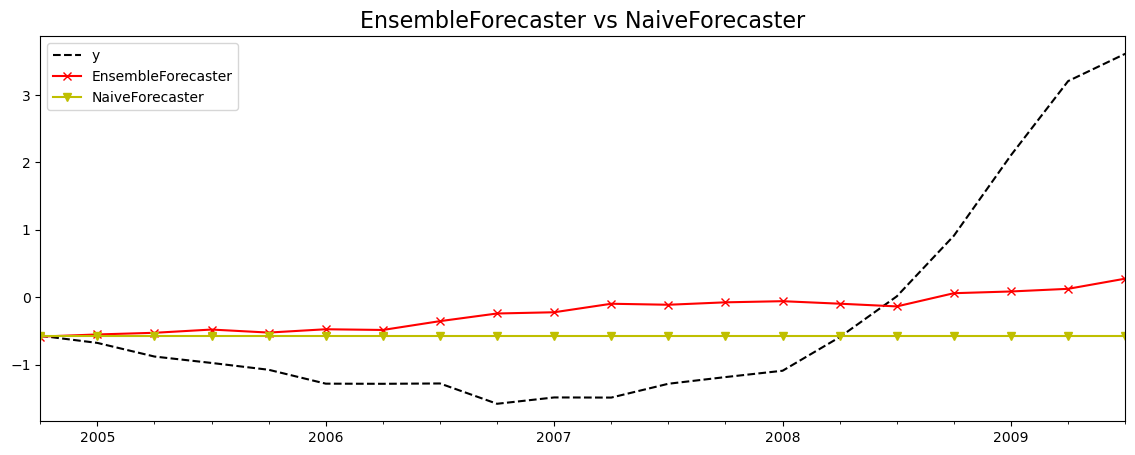

In [55]:
cond_deseason = ConditionalDeseasonalizer(sp=4)
detrend = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
for col in econ_df:
    econ_df[col] = cond_deseason.fit_transform(econ_df[col])
    econ_df[col] = detrend.fit_transform(econ_df[col])

y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])

test_size = 0.1
y_train, y_test = split_data(y, test_split=test_size)
exog_train, exog_test = split_data(exog, test_split=test_size)


# create list of regressors used with EnsembleForecaster
regressors = [
    ("LinearRegression", make_reduction(LinearRegression())),
    ("RandomForest", make_reduction(RandomForestRegressor())),
    ("SupportVectorRegressor", make_reduction(SVR())),
    ("GradientBoosting", make_reduction(GradientBoostingRegressor()))]


ensemble = EnsembleForecaster(regressors)
naive = NaiveForecaster() # base model

ensemble.fit(y=y_train, X=exog_train)
naive.fit(y=y_train, X=exog_train)

# predict by supplying forecast horizon and test exogenous variables
fh = ForecastingHorizon(y_test.index, is_relative=None)

y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
y_hat['EnsembleForecaster'] = ensemble.predict(fh=fh, X=exog_test)
y_hat['NaiveForecaster'] = naive.predict(fh=fh, X=exog_test)

y_hat.rename(columns={'test':'y'}, inplace=True)

print(evaluate(y_hat, y_train))


# plot both forecasters for visual comparision
styles = ['k--','rx-','yv-']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col, 
                    title='EnsembleForecaster vs NaiveForecaster')
plt.legend();


In [56]:
### working with AutoEnsembleForecaster
from sktime.forecasting.compose import AutoEnsembleForecaster

print(regressors)

auto = AutoEnsembleForecaster(forecasters=regressors,
                             method='feature-importance')
auto.fit(y=y_train, X=exog_train)

print(auto.weights_)

[('LinearRegression', RecursiveTabularRegressionForecaster(estimator=LinearRegression())), ('RandomForest', RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())), ('SupportVectorRegressor', RecursiveTabularRegressionForecaster(estimator=SVR())), ('GradientBoosting', RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))]
[0.1447979702280125, 0.28447310329823644, 0.22823851985019247, 0.3424904066235585]


In [57]:
y_hat['AutoEnsembleForecaster'] = auto.predict(fh=fh, X=exog_test)

evaluate(y_hat, y_train)
   ## these models can still be optimized to improve the predictions

sMAPE      MAPE      RMSE      MASE
NaiveForecaster         0.946033  2.490779  1.537844  4.522654
EnsembleForecaster      1.281749  1.170122  1.369023  4.616572
AutoEnsembleForecaster  1.309627  0.756775  1.394535  4.622832